# Data analysis on European football dataset

This is a data analysis on a football dataset. The main purpose of this analysis is to investigate relevant information for betting in football. The main research questions are:

- Which leagues are in which countries?
- Which leagues score the most/fewest goals?
- Who are the top scorers in each team and league?
- Can we identify teams with high winning rate?
- Is there such a thing as home advantage?
- Do teams make more goals at home?
- Can we predict how many goals each team will score in each match?
- Can we predict which team will win the match?

The main findings:

- There are ten leagues from ten countries in the data set.
- In the Netherlands Eredivisie matches are made the most goals in average, and in the France Ligue 1 matches the least.
- There is no clear pattern for teams with high winning rate. One of the most important factors is the results from the previous games, which increase the tendency of winning or losing.
- After a statistical analysis, we can conclude that there is a home advantage. The home teams have higher mean winning rate than the away teams.
- Predicting match outcome or goals with the given data is very difficult and have a lot of uncertainties.


My goal with this project is to practice conducting exploratory and statistical data analysis, data handling with sql and python, and forecasting with linear machine learning models. The project is part of Turing collage Data science course curriculum. 

The used data base is [here](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european)

Link for the Looker studio [dashboard](https://lookerstudio.google.com/reporting/4a4d01de-e79a-4b93-a448-98cca87e9af3).

**Contents**
1. [Importing packages and data](#1.-Importing-packages-and-data)

    1.1 [Database description](#1.1-Database-description)


2. [Data cleaning and preprocessing](#2.-Data-cleaning-and-preprocessing)
    
    2.1 [Data cleaning](#2.1-Data-cleaning)
    
    2.2 [Checking for outliers](#2.2-Checking-for-outliers)
    
    2.3 [Merging relevant tables](#2.3-Merging-relevant-tables)
    
  
3. [Exploratory data analysis](#3.-Exploratory-data-analysis)
    
    3.1 [Descriptive statistics](#3.1-Descriptive-statistics)
    
    3.2 [Leagues and seasons](#3.2-Leagues-and-seasons)
    
    3.3 [Winning and goal making](#3.3-Winning-and-goal-making)
    
    3.4 [Team attributes](#3.4-Team-attributes)
    
    3.5 [Player overall rating](#3.5-Player-overall-rating)
    
    3.6 [Playing tactics](#3.6-Playing-tactics)
    
    3.7 [Previous performance](#3.7-Previous-performance)

4. [Statistical analysis on home advantage](#4.-Statistical-analysis-on-home-advantage) 
    
    4.1 [Winning rates at home](#4.1-Winning-rates-at-home)
    
    4.2 [Amount of goals at home](#4.2-Amount-of-goals-at-home)
    
5. [Modelling](#5.-Modelling)
    
    5.1 [Predicting match outcome](#5.1-Predicting-match-outcome)  
    
    5.2 [Predicting match scores](#5.2-Predicting-match-scores)  


    
6. [Conclusion](#6.-Conclusion)


***
## 1. Importing packages and data

In [1]:
%load_ext nb_black
%matplotlib inline
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    auc,
    mean_squared_error,
    mean_absolute_error,
)
import re
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import duckdb

sns.set(rc={"figure.figsize": (10, 6)})

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
import preprocessingtools
import featureselection

<IPython.core.display.Javascript object>

### 1.1 Database description

In [3]:
conn = sqlite3.connect("archive/database.sqlite")
cur = conn.cursor()

<IPython.core.display.Javascript object>

In [4]:
pd.read_sql_query(
    """
SELECT * FROM sqlite_master WHERE type = 'table';""",
    conn,
)["name"]

0      sqlite_sequence
1    Player_Attributes
2               Player
3                Match
4               League
5              Country
6                 Team
7      Team_Attributes
Name: name, dtype: object

<IPython.core.display.Javascript object>

In [5]:
pd.read_sql_query(
    """
SELECT * FROM sqlite_sequence;""",
    conn,
).T

0        1       2      3       4                  5  \
name    Team  Country  League  Match  Player  Player_Attributes   
seq   103916    51958   51958  51958   11075             183978   

                    6  
name  Team_Attributes  
seq              1458

<IPython.core.display.Javascript object>

In [6]:
pd.read_sql_query(
    """
PRAGMA table_info([Player_Attributes]);""",
    conn,
).T

0                   1              2     3               4   \
cid               0                   1              2     3               4   
name             id  player_fifa_api_id  player_api_id  date  overall_rating   
type        INTEGER             INTEGER        INTEGER  TEXT         INTEGER   
notnull           0                   0              0     0               0   
dflt_value     None                None           None  None            None   
pk                1                   0              0     0               0   

                   5               6                    7   \
cid                 5               6                    7   
name        potential  preferred_foot  attacking_work_rate   
type          INTEGER            TEXT                 TEXT   
notnull             0               0                    0   
dflt_value       None            None                 None   
pk                  0               0                    0   

                             8         9   ...       32         33       34  \
cid                           8         9  ...       32         33       34   
name        defensive_work_rate  crossing  ...   vision  penalties  marking   
type                       TEXT   INTEGER  ...  INTEGER    INTEGER  INTEGER   
notnull                       0         0  ...        0          0        0   
dflt_value                 None      None  ...     None       None     None   
pk                            0         0  ...        0          0        0   

                         35              36         37           38  \
cid                      35              36         37           38   
name        standing_tackle  sliding_tackle  gk_diving  gk_handling   
type                INTEGER         INTEGER    INTEGER      INTEGER   
notnull                   0               0          0            0   
dflt_value             None            None       None         None   
pk                        0               0          0            0   

                    39              40           41  
cid                 39              40           41  
name        gk_kicking  gk_positioning  gk_reflexes  
type           INTEGER         INTEGER      INTEGER  
notnull              0               0            0  
dflt_value        None            None         None  
pk                   0               0            0  

[6 rows x 42 columns]

<IPython.core.display.Javascript object>

In [7]:
pd.read_sql_query(
    """
PRAGMA table_info([Player]);""",
    conn,
).T

0              1            2                   3         4  \
cid               0              1            2                   3         4   
name             id  player_api_id  player_name  player_fifa_api_id  birthday   
type        INTEGER        INTEGER         TEXT             INTEGER      TEXT   
notnull           0              0            0                   0         0   
dflt_value     None           None         None                None      None   
pk                1              0            0                   0         0   

                  5        6  
cid               5        6  
name         height   weight  
type        INTEGER  INTEGER  
notnull           0        0  
dflt_value     None     None  
pk                0        0

<IPython.core.display.Javascript object>

In [8]:
pd.read_sql_query(
    """
PRAGMA table_info([Match]);""",
    conn,
).T

0           1          2       3        4     5    \
cid               0           1          2       3        4     5   
name             id  country_id  league_id  season    stage  date   
type        INTEGER     INTEGER    INTEGER    TEXT  INTEGER  TEXT   
notnull           0           0          0       0        0     0   
dflt_value     None        None       None    None     None  None   
pk                1           0          0       0        0     0   

                     6                 7                 8               9    \
cid                    6                 7                 8               9   
name        match_api_id  home_team_api_id  away_team_api_id  home_team_goal   
type             INTEGER           INTEGER           INTEGER         INTEGER   
notnull                0                 0                 0               0   
dflt_value          None              None              None            None   
pk                     0                 0                 0               0   

            ...      105      106      107      108      109      110  \
cid         ...      105      106      107      108      109      110   
name        ...      SJA      VCH      VCD      VCA      GBH      GBD   
type        ...  NUMERIC  NUMERIC  NUMERIC  NUMERIC  NUMERIC  NUMERIC   
notnull     ...        0        0        0        0        0        0   
dflt_value  ...     None     None     None     None     None     None   
pk          ...        0        0        0        0        0        0   

                111      112      113      114  
cid             111      112      113      114  
name            GBA      BSH      BSD      BSA  
type        NUMERIC  NUMERIC  NUMERIC  NUMERIC  
notnull           0        0        0        0  
dflt_value     None     None     None     None  
pk                0        0        0        0  

[6 rows x 115 columns]

<IPython.core.display.Javascript object>

In [9]:
pd.read_sql_query(
    """
PRAGMA table_info([League]);""",
    conn,
).T

0           1     2
cid               0           1     2
name             id  country_id  name
type        INTEGER     INTEGER  TEXT
notnull           0           0     0
dflt_value     None        None  None
pk                1           0     0

<IPython.core.display.Javascript object>

In [10]:
pd.read_sql_query(
    """
PRAGMA table_info([Country]);""",
    conn,
).T

0     1
cid               0     1
name             id  name
type        INTEGER  TEXT
notnull           0     0
dflt_value     None  None
pk                1     0

<IPython.core.display.Javascript object>

In [11]:
pd.read_sql_query(
    """
PRAGMA table_info([Team]);""",
    conn,
).T

0            1                 2               3  \
cid               0            1                 2               3   
name             id  team_api_id  team_fifa_api_id  team_long_name   
type        INTEGER      INTEGER           INTEGER            TEXT   
notnull           0            0                 0               0   
dflt_value     None         None              None            None   
pk                1            0                 0               0   

                          4  
cid                       4  
name        team_short_name  
type                   TEXT  
notnull                   0  
dflt_value             None  
pk                        0

<IPython.core.display.Javascript object>

In [12]:
pd.read_sql_query(
    """
PRAGMA table_info([Team_Attributes]);""",
    conn,
).T

0                 1            2     3                 4   \
cid               0                 1            2     3                 4   
name             id  team_fifa_api_id  team_api_id  date  buildUpPlaySpeed   
type        INTEGER           INTEGER      INTEGER  TEXT           INTEGER   
notnull           0                 0            0     0                 0   
dflt_value     None              None         None  None              None   
pk                1                 0            0     0                 0   

                               5                     6   \
cid                             5                     6   
name        buildUpPlaySpeedClass  buildUpPlayDribbling   
type                         TEXT               INTEGER   
notnull                         0                     0   
dflt_value                   None                  None   
pk                              0                     0   

                                   7                   8   \
cid                                 7                   8   
name        buildUpPlayDribblingClass  buildUpPlayPassing   
type                             TEXT             INTEGER   
notnull                             0                   0   
dflt_value                       None                None   
pk                                  0                   0   

                                 9   ...                      15  \
cid                               9  ...                      15   
name        buildUpPlayPassingClass  ...  chanceCreationShooting   
type                           TEXT  ...                 INTEGER   
notnull                           0  ...                       0   
dflt_value                     None  ...                    None   
pk                                0  ...                       0   

                                     16                              17  \
cid                                  16                              17   
name        chanceCreationShootingClass  chanceCreationPositioningClass   
type                               TEXT                            TEXT   
notnull                               0                               0   
dflt_value                         None                            None   
pk                                    0                               0   

                         18                    19                 20  \
cid                      18                    19                 20   
name        defencePressure  defencePressureClass  defenceAggression   
type                INTEGER                  TEXT            INTEGER   
notnull                   0                     0                  0   
dflt_value             None                  None               None   
pk                        0                     0                  0   

                                21                22                     23  \
cid                             21                22                     23   
name        defenceAggressionClass  defenceTeamWidth  defenceTeamWidthClass   
type                          TEXT           INTEGER                   TEXT   
notnull                          0                 0                      0   
dflt_value                    None              None                   None   
pk                               0                 0                      0   

                                  24  
cid                               24  
name        defenceDefenderLineClass  
type                            TEXT  
notnull                            0  
dflt_value                      None  
pk                                 0  

[6 rows x 25 columns]

<IPython.core.display.Javascript object>

***
## 2. Data cleaning and preprocessing

### 2.1 Data cleaning

Here the data is checked for null values and duplicates. No duplicate rows found. There is null values that should be considered.

In [13]:
preprocessingtools.check_nulls_sqlite("Country", cur)
preprocessingtools.check_dublicates_sqlite("Country", cur)

Number of null values:
id 0
name 0
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

In [14]:
preprocessingtools.check_nulls_sqlite("League", cur)
preprocessingtools.check_dublicates_sqlite("League", cur)

Number of null values:
id 0
country_id 0
name 0
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

In [15]:
preprocessingtools.check_nulls_sqlite("Player", cur)
preprocessingtools.check_dublicates_sqlite("Player", cur)

Number of null values:
id 0
player_api_id 0
player_name 0
player_fifa_api_id 0
birthday 0
height 0
weight 0
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

The FIFA id is missing for the some of the teams. The column is dropped from the table.

In [16]:
preprocessingtools.check_nulls_sqlite("Team", cur)
preprocessingtools.check_dublicates_sqlite("Team", cur)

Number of null values:
id 0
team_api_id 0
team_fifa_api_id 11
team_long_name 0
team_short_name 0
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

In [17]:
cur.execute(
    """
    CREATE TEMPORARY TABLE Team_temp
    AS
    SELECT id, team_api_id, team_long_name, team_short_name
    FROM Team
"""
)

<IPython.core.display.Javascript object>

In [18]:
preprocessingtools.check_nulls_sqlite("Team_Attributes", cur)
preprocessingtools.check_dublicates_sqlite("Team_Attributes", cur)

Number of null values:
id 0
team_fifa_api_id 0
team_api_id 0
date 0
buildUpPlaySpeed 0
buildUpPlaySpeedClass 0
buildUpPlayDribbling 969
buildUpPlayDribblingClass 0
buildUpPlayPassing 0
buildUpPlayPassingClass 0
buildUpPlayPositioningClass 0
chanceCreationPassing 0
chanceCreationPassingClass 0
chanceCreationCrossing 0
chanceCreationCrossingClass 0
chanceCreationShooting 0
chanceCreationShootingClass 0
chanceCreationPositioningClass 0
defencePressure 0
defencePressureClass 0
defenceAggression 0
defenceAggressionClass 0
defenceTeamWidth 0
defenceTeamWidthClass 0
defenceDefenderLineClass 0
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

In [19]:
pd.read_sql_query(
    """
    SELECT 
        CASE 
            WHEN date BETWEEN '2008/08/01' AND '2009/06/01' THEN '2008/2009'
            WHEN date BETWEEN '2009/08/01' AND '2010/06/01'  THEN '2009/2010'
            WHEN date BETWEEN '2010/08/01' AND '2011/06/01'  THEN '2010/2011'
            WHEN date BETWEEN '2011/08/01' AND '2012/06/01'  THEN '2011/2012'
            WHEN date BETWEEN '2012/08/01' AND '2013/06/01'  THEN '2012/2013'
            WHEN date BETWEEN '2013/08/01' AND '2014/06/01'  THEN '2013/2014'
            WHEN date BETWEEN '2014/08/01' AND '2015/06/01'  THEN '2014/2015'
        END AS season,
        COUNT(*)
    FROM Team_Attributes 
    WHERE buildUpPlayDribbling IS NULL 
    GROUP BY 1""",
    conn,
)

season  COUNT(*)
0  2009/2010       241
1  2010/2011       244
2  2011/2012       242
3  2012/2013       242

<IPython.core.display.Javascript object>

buildUpPlayDribbling feature is missing in the majority of teams in seasons 2009-2013. Therefore the column is dropped. 

In the table, there is a numerical and categorical features representing same attributes for each class. For our purposes the numerical feature is only needed, and hence, the categorical features are dropped. Finally, a season column is created for the table.

In [20]:
cur.execute(
    """
    CREATE TEMPORARY TABLE Team_Attributes_temp
    AS
    SELECT 
        id,
        CASE 
            WHEN date BETWEEN '2008/08/01' AND '2009/06/01' THEN '2008/2009'
            WHEN date BETWEEN '2009/08/01' AND '2010/06/01'  THEN '2009/2010'
            WHEN date BETWEEN '2010/08/01' AND '2011/06/01'  THEN '2010/2011'
            WHEN date BETWEEN '2011/08/01' AND '2012/06/01'  THEN '2011/2012'
            WHEN date BETWEEN '2012/08/01' AND '2013/06/01'  THEN '2012/2013'
            WHEN date BETWEEN '2013/08/01' AND '2014/06/01'  THEN '2013/2014'
            WHEN date BETWEEN '2014/08/01' AND '2015/06/01'  THEN '2014/2015'
        END AS season,
        team_api_id,
        date,
        buildUpPlaySpeed,
        buildUpPlayPassing,
        chanceCreationPassing,
        chanceCreationCrossing,
        chanceCreationShooting,
        defencePressure,
        defenceAggression,
        defenceTeamWidth
    FROM Team_Attributes 
"""
)

<IPython.core.display.Javascript object>

In [21]:
team_attributes_temp_df = pd.read_sql_query("SELECT * FROM Team_Attributes_temp", conn)
team_attributes_temp_df.shape

(1458, 12)

<IPython.core.display.Javascript object>

There is a lot of missing values in different columns in the Player attributes table. In our analysis, we will concentrate on the overall rating of the players only so the other attributes are dropped from the analysis. The rows with null values are removed from the table.

In [22]:
preprocessingtools.check_nulls_sqlite("Player_Attributes", cur)
preprocessingtools.check_dublicates_sqlite("Player_Attributes", cur)

Number of null values:
id 0
player_fifa_api_id 0
player_api_id 0
date 0
overall_rating 836
potential 836
preferred_foot 836
attacking_work_rate 3230
defensive_work_rate 836
crossing 836
finishing 836
heading_accuracy 836
short_passing 836
volleys 2713
dribbling 836
curve 2713
free_kick_accuracy 836
long_passing 836
ball_control 836
acceleration 836
sprint_speed 836
agility 2713
reactions 836
balance 2713
shot_power 836
jumping 2713
stamina 836
strength 836
long_shots 836
aggression 836
interceptions 836
positioning 836
vision 2713
penalties 836
marking 836
standing_tackle 836
sliding_tackle 2713
gk_diving 836
gk_handling 836
gk_kicking 836
gk_positioning 836
gk_reflexes 836
Number of dublicate rows:
0


<IPython.core.display.Javascript object>

In [23]:
player_overallrating_df = pd.read_sql_query(
    "SELECT player_api_id , date, overall_rating FROM Player_Attributes WHERE overall_rating IS NOT NULL",
    conn,
)
player_overallrating_df.shape

(183142, 3)

<IPython.core.display.Javascript object>

Match table has few columns with null values. 

The table is divided in to three tables as almost half of the matches are missing in-game data, e.g. detailed goal and shoton information. The table is divided into a table with in-game data and to a table with team related data such player coordinates, and lastly to a table with player ids. Then the rows with null values are removed. The betting odds are not included as the idea is to built own model that could be used for creating betting odds.

In addition, match outcome, home_win, away_win and draw features are created for each match.

In [24]:
preprocessingtools.check_nulls_sqlite("Match", cur)
preprocessingtools.check_dublicates_sqlite("Match", cur)

Number of null values:
id 0
country_id 0
league_id 0
season 0
stage 0
date 0
match_api_id 0
home_team_api_id 0
away_team_api_id 0
home_team_goal 0
away_team_goal 0
home_player_X1 1821
home_player_X2 1821
home_player_X3 1832
home_player_X4 1832
home_player_X5 1832
home_player_X6 1832
home_player_X7 1832
home_player_X8 1832
home_player_X9 1832
home_player_X10 1832
home_player_X11 1832
away_player_X1 1832
away_player_X2 1832
away_player_X3 1832
away_player_X4 1832
away_player_X5 1832
away_player_X6 1832
away_player_X7 1832
away_player_X8 1832
away_player_X9 1833
away_player_X10 1833
away_player_X11 1839
home_player_Y1 1821
home_player_Y2 1821
home_player_Y3 1832
home_player_Y4 1832
home_player_Y5 1832
home_player_Y6 1832
home_player_Y7 1832
home_player_Y8 1832
home_player_Y9 1832
home_player_Y10 1832
home_player_Y11 1832
away_player_Y1 1832
away_player_Y2 1832
away_player_Y3 1832
away_player_Y4 1832
away_player_Y5 1832
away_player_Y6 1832
away_player_Y7 1832
away_player_Y8 1832
away_playe

<IPython.core.display.Javascript object>

First, the table with all the team related data, player coordinates etc.

In [25]:
cur.execute(
    """
    CREATE TEMP TABLE Match2
    AS
    SELECT 
        id,
        country_id
        league_id,
        season,
        stage,
        date,
        match_api_id,
        home_team_api_id,
        away_team_api_id,
        home_team_goal,
        away_team_goal,
        CASE
            WHEN home_team_goal > away_team_goal THEN 1
            WHEN home_team_goal < away_team_goal THEN 0
            ELSE 0
        END AS home_win,
        CASE
            WHEN home_team_goal > away_team_goal THEN 0
            WHEN home_team_goal < away_team_goal THEN 1
            ELSE 0
        END AS away_win,
        CASE
            WHEN home_team_goal = away_team_goal THEN 1
            ELSE 0
        END AS draw,
        CASE
            WHEN home_team_goal > away_team_goal THEN 'home'
            WHEN home_team_goal < away_team_goal THEN 'away'
            ELSE 'draw'
        END AS match_outcome,
        home_player_X1,
        home_player_X2,
        home_player_X3,
        home_player_X4,
        home_player_X5,
        home_player_X6,
        home_player_X7,
        home_player_X8,
        home_player_X9,
        home_player_X10,
        home_player_X11,
        away_player_X1,
        away_player_X2,
        away_player_X3,
        away_player_X4,
        away_player_X5,
        away_player_X6,
        away_player_X7,
        away_player_X8,
        away_player_X9,
        away_player_X10,
        away_player_X11,
        home_player_Y1,
        home_player_Y2,
        home_player_Y3,
        home_player_Y4,
        home_player_Y5,
        home_player_Y6,
        home_player_Y7,
        home_player_Y8,
        home_player_Y9,
        home_player_Y10,
        home_player_Y11,
        away_player_Y1,
        away_player_Y2,
        away_player_Y3,
        away_player_Y4,
        away_player_Y5,
        away_player_Y6,
        away_player_Y7,
        away_player_Y8,
        away_player_Y9,
        away_player_Y10,
        away_player_Y11
    FROM Match 
"""
)

<IPython.core.display.Javascript object>

In [26]:
preprocessingtools.drop_rows_with_nulls_sqlite("Match2", "Match_temp", cur)

<IPython.core.display.Javascript object>

In [27]:
preprocessingtools.check_nulls_sqlite("Match_temp", cur)

Number of null values:
id 0
league_id 0
season 0
stage 0
date 0
match_api_id 0
home_team_api_id 0
away_team_api_id 0
home_team_goal 0
away_team_goal 0
home_win 0
away_win 0
draw 0
match_outcome 0
home_player_X1 0
home_player_X2 0
home_player_X3 0
home_player_X4 0
home_player_X5 0
home_player_X6 0
home_player_X7 0
home_player_X8 0
home_player_X9 0
home_player_X10 0
home_player_X11 0
away_player_X1 0
away_player_X2 0
away_player_X3 0
away_player_X4 0
away_player_X5 0
away_player_X6 0
away_player_X7 0
away_player_X8 0
away_player_X9 0
away_player_X10 0
away_player_X11 0
home_player_Y1 0
home_player_Y2 0
home_player_Y3 0
home_player_Y4 0
home_player_Y5 0
home_player_Y6 0
home_player_Y7 0
home_player_Y8 0
home_player_Y9 0
home_player_Y10 0
home_player_Y11 0
away_player_Y1 0
away_player_Y2 0
away_player_Y3 0
away_player_Y4 0
away_player_Y5 0
away_player_Y6 0
away_player_Y7 0
away_player_Y8 0
away_player_Y9 0
away_player_Y10 0
away_player_Y11 0


<IPython.core.display.Javascript object>

Next, all the player id for each match are separated to its own table.

In [28]:
cur.execute(
    """
    CREATE TEMP TABLE MatchPlayers
    AS
    SELECT 
        id,
        date,
        home_player_1,
        home_player_2,
        home_player_3,
        home_player_4,
        home_player_5,
        home_player_6,
        home_player_7,
        home_player_8,
        home_player_9,
        home_player_10,
        home_player_11,
        away_player_1,
        away_player_2,
        away_player_3,
        away_player_4,
        away_player_5,
        away_player_6,
        away_player_7,
        away_player_8,
        away_player_9,
        away_player_10,
        away_player_11
    FROM Match 
"""
)

<IPython.core.display.Javascript object>

In [29]:
preprocessingtools.drop_rows_with_nulls_sqlite("MatchPlayers", "MatchPlayers_temp", cur)

<IPython.core.display.Javascript object>

Finally, a table that has in-game details of each match.

In [30]:
cur.execute(
    """
    CREATE TEMP TABLE MatchScoreDetails_temp
    AS
    SELECT 
        id,
        country_id
        league_id,
        season,
        stage,
        date,
        match_api_id,
        home_team_api_id,
        away_team_api_id,
        home_team_goal,
        away_team_goal,
        goal,
        shoton,
        shotoff,
        foulcommit,
        card,
        cross,
        corner,
        possession
    FROM Match 
    WHERE goal is NOT NULL
"""
)

<IPython.core.display.Javascript object>

In [31]:
preprocessingtools.check_nulls_sqlite("MatchScoreDetails_temp", cur)

Number of null values:
id 0
league_id 0
season 0
stage 0
date 0
match_api_id 0
home_team_api_id 0
away_team_api_id 0
home_team_goal 0
away_team_goal 0
goal 0
shoton 0
shotoff 0
foulcommit 0
card 0
cross 0
corner 0
possession 0


<IPython.core.display.Javascript object>

### 2.3 Merging relevant tables

Here all the relevant data is combined for model building and further analysis. 

A new large match table is created that will include all information for each match and some new features. This table will contain:

- Players overall rating 
    - Instead of using all the attributes, only the overall rating is used, because it is a good metric to give a summary of the player's abilities and effectiveness on the field.
- Historical performance of each team
    - Points won from the last five games
        - This is used to evaluate the medium term team performance
    - Average goals from the last ten games
        - This is used to evaluate the long term team performance
    - Outcome of the last match teams played against each other
    - Goal difference of the last match (home - away)
        - These two are used to evaluate the short term team performance against each other
- Playing tactics
    - The opening formation of the teams is defined based on the players coordinates  


In [32]:
match_temp_df = pd.read_sql_query(
    """
    SELECT *
    FROM Match_temp
    """,
    conn,
)
match_temp_df.shape

(24140, 58)

<IPython.core.display.Javascript object>

In [33]:
match_player_df = pd.read_sql_query(
    """
    SELECT *
    FROM MatchPlayers_temp
    """,
    conn,
)
match_player_df.shape

(21374, 24)

<IPython.core.display.Javascript object>

In [34]:
matchscore_temp_df = pd.read_sql_query(
    """
    SELECT *
    FROM MatchScoreDetails_temp
    """,
    conn,
)
matchscore_temp_df.shape

(14217, 18)

<IPython.core.display.Javascript object>

First, all overall rating of players for every match is searched. The player ratings are updated frequently so the newest available data before the match is used. 

In [35]:
match_with_players_df = preprocessingtools.find_team_overall_scores(
    "match_player_df", "player_overallrating_df"
)
match_with_players_df.shape

Combining data.
Data collected in 2.8 minutes


(21374, 23)

<IPython.core.display.Javascript object>

In [36]:
match_with_players_df

id  home_player_1_rating  home_player_2_rating  \
0        190                    67                    72   
1        466                    58                    57   
2        474                    66                    68   
3        478                    61                    66   
4        538                    60                    61   
...      ...                   ...                   ...   
21369  22273                    78                    79   
21370  22235                    78                    76   
21371  21998                    74                    75   
21372  21941                    76                    69   
21373   6697                    74                    75   

       home_player_3_rating  home_player_4_rating  home_player_5_rating  \
0                        72                    69                    72   
1                        63                    57                    62   
2                        65                    64                    68   
3                        61                    61                    60   
4                        62                    60                    57   
...                     ...                   ...                   ...   
21369                    71                    78                    71   
21370                    80                    76                    78   
21371                    80                    71                    74   
21372                    72                    69                    68   
21373                    72                    80                    75   

       home_player_6_rating  home_player_7_rating  home_player_8_rating  \
0                        71                    75                    74   
1                        65                    60                    62   
2                        66                    65                    70   
3                        65                    67                    66   
4                        58                    62                    64   
...                     ...                   ...                   ...   
21369                    75                    76                    74   
21370                    82                    76                    79   
21371                    78                    75                    76   
21372                    64                    68                    74   
21373                    71                    68                    75   

       home_player_9_rating  ...  away_player_2_rating  away_player_3_rating  \
0                        74  ...                    69                    67   
1                        59  ...                    67                    66   
2                        65  ...                    71                    69   
3                        49  ...                    72                    69   
4                        60  ...                    63                    64   
...                     ...  ...                   ...                   ...   
21369                    69  ...                    80                    76   
21370                    86  ...                    73                    77   
21371                    77  ...                    73                    77   
21372                    70  ...                    73                    77   
21373                    66  ...                    74                    76   

       away_player_4_rating  away_player_5_rating  away_player_6_rating  \
0                        66                    67                    70   
1                        67                    58                    70   
2                        70                    69                    68   
3                        72                    56                    71   
4                        60                    65                    67   
...                     ...                   ...                   ...   
2

<IPython.core.display.Javascript object>

Then the history features for each match are created. The number of points from the last five games for both home and away teams. Then the result of the last match home and away team played against each other.

In [37]:
match_history_df = duckdb.query(
    """
SELECT 
    m.id, 
    COALESCE((
        SELECT SUM(points)
        FROM (
            SELECT
                CASE 
                    WHEN home_team_api_id = m.home_team_api_id AND home_win = 1 THEN 3 
                    WHEN away_team_api_id = m.home_team_api_id AND away_win = 1 THEN 3
                    WHEN (away_team_api_id = m.home_team_api_id) OR (home_team_api_id = m.home_team_api_id) AND draw = 1 THEN 1
                    ELSE 0
                END points
            FROM match_temp_df 
            WHERE 
                (home_team_api_id = m.home_team_api_id OR away_team_api_id = m.home_team_api_id) 
                AND date < m.date 
            ORDER BY date DESC
            LIMIT 5
        ) tb 
    ),0) AS home_points_history,
    COALESCE((
        SELECT SUM(points)
        FROM (
            SELECT
                CASE 
                    WHEN home_team_api_id = m.away_team_api_id AND home_win = 1 THEN 3 
                    WHEN away_team_api_id = m.away_team_api_id AND away_win = 1 THEN 3
                    WHEN (away_team_api_id = m.away_team_api_id) OR (home_team_api_id = m.away_team_api_id) AND draw = 1 THEN 1
                    ELSE 0
                END points
            FROM match_temp_df 
            WHERE 
                (home_team_api_id = m.away_team_api_id OR away_team_api_id = m.away_team_api_id) 
                AND date < m.date 
            ORDER BY date DESC
            LIMIT 5
        ) tb 
    ),0) AS away_points_history,
    COALESCE((
            SELECT
                CASE 
                    WHEN (away_win = 1) AND (home_team_api_id = m.home_team_api_id) THEN -1 
                    WHEN (home_team_api_id = m.away_team_api_id) AND (home_win = 1) THEN -1
                    WHEN (home_team_api_id = m.home_team_api_id) AND (home_win = 1) THEN 1 
                    WHEN (home_team_api_id = m.away_team_api_id) AND (away_win = 1) THEN 1
                    ELSE 0
                END result
            FROM match_temp_df 
            WHERE 
                ((home_team_api_id = m.away_team_api_id AND away_team_api_id = m.home_team_api_id) 
                OR (home_team_api_id = m.home_team_api_id AND away_team_api_id = m.away_team_api_id))
                AND (date < m.date) 
            ORDER BY date DESC
            LIMIT 1
        ) ,0) AS last_match_outcome 
FROM match_temp_df m
"""
).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

<IPython.core.display.Javascript object>

The result of the last match team player against each other is shown so that home team won is '1', draw is '0' and away team won is '-1'.

In [38]:
match_history_df

id  home_points_history  away_points_history  last_match_outcome
0        145                  0.0                  0.0                   0
1        146                  0.0                  0.0                   0
2        147                  0.0                  0.0                   0
3        148                  0.0                  0.0                   0
4        149                  0.0                  0.0                   0
...      ...                  ...                  ...                 ...
24135  25975                  5.0                  6.0                   1
24136  25976                  7.0                  7.0                  -1
24137  25977                 11.0                 10.0                   0
24138  25978                  5.0                  6.0                   0
24139  25979                 10.0                 15.0                   0

[24140 rows x 4 columns]

<IPython.core.display.Javascript object>

Here, the mean number of goals from the last ten games for both home and away teams and the goal difference from the last match are defined.

In [39]:
goal_history_df = duckdb.query(
    """
SELECT 
    m.id, 
    COALESCE((
        SELECT AVG(goals)
        FROM (
            SELECT
                CASE 
                    WHEN home_team_api_id = m.home_team_api_id THEN home_team_goal 
                    WHEN away_team_api_id = m.home_team_api_id THEN away_team_goal
                    ELSE 0
                END goals
            FROM match_temp_df 
            WHERE 
                (home_team_api_id = m.home_team_api_id OR away_team_api_id = m.home_team_api_id) 
                AND date < m.date 
            ORDER BY date DESC
            LIMIT 10
        ) tb 
    ),0) AS home_goals_history,
    COALESCE((
        SELECT AVG(goals)
        FROM (
            SELECT
                CASE 
                    WHEN home_team_api_id = m.away_team_api_id THEN home_team_goal 
                    WHEN away_team_api_id = m.away_team_api_id THEN away_team_goal
                    ELSE 0
                END goals
            FROM match_temp_df 
            WHERE 
                (home_team_api_id = m.away_team_api_id OR away_team_api_id = m.away_team_api_id) 
                AND date < m.date 
            ORDER BY date DESC
            LIMIT 10
        ) tb 
    ),0) AS away_goals_history,
    COALESCE((
            SELECT
                CASE 
                    WHEN (home_team_api_id = m.home_team_api_id) THEN home_team_goal - away_team_goal
                    WHEN (home_team_api_id = m.away_team_api_id) THEN away_team_goal - home_team_goal
                    ELSE 0
                END result
            FROM match_temp_df 
            WHERE 
                ((home_team_api_id = m.away_team_api_id AND away_team_api_id = m.home_team_api_id) 
                OR (home_team_api_id = m.home_team_api_id AND away_team_api_id = m.away_team_api_id))
                AND (date < m.date) 
            ORDER BY date DESC
            LIMIT 1
        ) ,0) AS last_match_goal_difference 
FROM match_temp_df m
"""
).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

<IPython.core.display.Javascript object>

In [40]:
goal_history_df

id  home_goals_history  away_goals_history  \
0        145                0.00                 0.0   
1        146                0.00                 0.0   
2        147                0.00                 0.0   
3        148                0.00                 0.0   
4        149                0.00                 0.0   
...      ...                 ...                 ...   
24135  25975                1.30                 1.6   
24136  25976                0.80                 1.7   
24137  25977                3.10                 1.9   
24138  25978                0.75                 1.9   
24139  25979                1.90                 2.8   

       last_match_goal_difference  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
...                           ...  
24135                           1  
24136                          -2  
24137                           0  
24138                           0  
24139                           0  

[24140 rows x 4 columns]

<IPython.core.display.Javascript object>

Next, the player overall ratings, match history features and team attributes are combined with match data. The team attributes are given for each season separately so the newest available data before the match is used.

In [41]:
matches_modelling_df = duckdb.query(
    """
    WITH home_team_attr AS (
    SELECT
        team_api_id home_id,
        season,
        buildUpPlaySpeed home_buildUpPlaySpeed,
        buildUpPlayPassing home_buildUpPlayPassing,
        chanceCreationPassing home_chanceCreationPassing,
        chanceCreationCrossing home_chanceCreationCrossing,
        chanceCreationShooting home_chanceCreationShooting,
        defencePressure home_defencePressure,
        defenceAggression home_defenceAggression
    FROM team_attributes_temp_df),
    away_team_attr AS (
    SELECT
        team_api_id away_id,
        season,
        buildUpPlaySpeed away_buildUpPlaySpeed,
        buildUpPlayPassing away_buildUpPlayPassing,
        chanceCreationPassing away_chanceCreationPassing,
        chanceCreationCrossing away_chanceCreationCrossing,
        chanceCreationShooting away_chanceCreationShooting,
        defencePressure away_defencePressure,
        defenceAggression away_defenceAggression
    FROM team_attributes_temp_df)

    SELECT 
        m.*, 
        mh.* EXCLUDE (id), 
        gh.* EXCLUDE (id), 
        mp.* EXCLUDE (id),
        h.* EXCLUDE(home_id, season),
        a.* EXCLUDE(away_id, season)
    FROM match_temp_df m
    INNER JOIN match_history_df mh
    ON m.id = mh.id
    INNER JOIN goal_history_df gh
    ON m.id = gh.id
    INNER JOIN match_with_players_df mp
    ON m.id = mp.id
    INNER JOIN home_team_attr h
    ON m.home_team_api_id = h.home_id AND m.season = h.season
    INNER JOIN away_team_attr a
    ON m.away_team_api_id = a.away_id AND m.season = a.season
"""
).df()

<IPython.core.display.Javascript object>

In [42]:
matches_modelling_df.set_index("id", inplace=True)

<IPython.core.display.Javascript object>

In [43]:
matches_modelling_df.shape

(16515, 99)

<IPython.core.display.Javascript object>

In [44]:
matches_modelling_df.head()

league_id     season  stage                 date  match_api_id  \
id                                                                    
311          1  2009/2010      1  2009-08-01 00:00:00        665323   
323          1  2009/2010     11  2009-10-18 00:00:00        665427   
327          1  2009/2010     11  2009-10-17 00:00:00        665435   
328          1  2009/2010     12  2009-10-24 00:00:00        665438   
333          1  2009/2010     12  2009-10-25 00:00:00        665445   

     home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
id                                                                        
311              8571              8635               0               2   
323              9987              8203               1               2   
327             10001              9985               2               0   
328              9985             10000               1               1   
333              8203              8635               0               2   

     home_win  ...  home_chanceCreationShooting  home_defencePressure  \
id             ...                                                      
311         0  ...                           50                    60   
323         0  ...                           60                    70   
327         1  ...                           55                    70   
328         0  ...                           65                    70   
333         0  ...                           50                    60   

    home_defenceAggression  away_buildUpPlaySpeed  away_buildUpPlayPassing  \
id                                                                           
311                     60                     50                       35   
323                     65                     65                       60   
327                     70                     53                       40   
328                     70                     65                       60   
333                     70                     50                       35   

     away_chanceCreationPassing  away_chanceCreationCrossing  \
id                                                             
311                          70                           50   
323                          50                           40   
327                          55                           55   
328                          60                           40   
333                          70                           50   

     away_chanceCreationShooting  away_defencePressure  away_defenceAggression  
id                                                                              
311                           60                    70                      50  
323                           50                    60                      70  
327                           65                    70                      70  
328                           50                    70                      60  
333                           60                    70                      50  

[5 rows x 99 columns]

<IPython.core.display.Javascript object>

Finally, the teams formation for each match is determined based on the Y-coordinate of the players. The goal keepers location is irrelevant as it is the same for every formation. Then the player coordinate features are dropped from the table.

In [45]:
matches_modelling_df[["home_formation", "away_formation"]] = matches_modelling_df.apply(
    lambda row: preprocessingtools.find_team_formation(row),
    axis=1,
    result_type="expand",
)

<IPython.core.display.Javascript object>

In [46]:
home_coordinates_Y = ["home_player_Y" + str(X) for X in range(1, 12)]
away_coordinates_Y = ["away_player_Y" + str(X) for X in range(1, 12)]
home_coordinates_X = ["home_player_X" + str(X) for X in range(1, 12)]
away_coordinates_X = ["away_player_X" + str(X) for X in range(1, 12)]
columns = (
    home_coordinates_Y + away_coordinates_Y + home_coordinates_X + away_coordinates_X
)

<IPython.core.display.Javascript object>

In [47]:
matches_modelling_df.drop(columns=columns, inplace=True)

<IPython.core.display.Javascript object>

In [48]:
matches_modelling_df

league_id     season  stage                 date  match_api_id  \
id                                                                      
311            1  2009/2010      1  2009-08-01 00:00:00        665323   
323            1  2009/2010     11  2009-10-18 00:00:00        665427   
327            1  2009/2010     11  2009-10-17 00:00:00        665435   
328            1  2009/2010     12  2009-10-24 00:00:00        665438   
333            1  2009/2010     12  2009-10-25 00:00:00        665445   
...          ...        ...    ...                  ...           ...   
12745      10257  2014/2015     30  2015-04-11 00:00:00       1786301   
1383           1  2014/2015     24  2015-01-31 00:00:00       1718007   
5307        4769  2009/2010     23  2010-02-06 00:00:00        654369   
1443           1  2014/2015      4  2014-08-16 00:00:00       1717843   
967            1  2011/2012      6  2011-09-09 00:00:00       1032734   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
id                                                                          
311                8571              8635               0               2   
323                9987              8203               1               2   
327               10001              9985               2               0   
328                9985             10000               1               1   
333                8203              8635               0               2   
...                 ...               ...             ...             ...   
12745             10233              8529               2               0   
1383              10001              9984               1               0   
5307               9874              8481               1               1   
1443               8573              8203               2               0   
967                9997              9987               3               4   

       home_win  ...  home_defenceAggression  away_buildUpPlaySpeed  \
id               ...                                                  
311           0  ...                      60                     50   
323           0  ...                      65                     65   
327           1  ...                      70                     53   
328           0  ...                      70                     65   
333           0  ...                      70                     50   
...         ...  ...                     ...                    ...   
12745         1  ...                      47                     67   
1383          1  ...                      45                     53   
5307          0  ...                      30                     65   
1443          1  ...                      47                     52   
967           0  ...                      40                     53   

      away_buildUpPlayPassing  away_chanceCreationPassing  \
id                                                          
311                        35                          70   
323                        60                          50   
327                        40                          55   
328                        60                          60   
333                        35                          70   
...                       ...                         ...   
12745                      35                          69   
1383                       43                          52   
5307                       40                          60   
1443                       40                          47   
967                        55                          55   

       away_chanceCreationCrossing  away_chanceCreationShooting  \
id                                                                
311                             50                           60   
323                             40                           50   
327                             55                           65   
32

<IPython.core.display.Javascript object>

These tables are used for obtain basic information from the European soccer leagues.

In [49]:
goals_df = pd.read_sql_query(
    """
    SELECT goal AS xml, league_id
    FROM MatchScoreDetails_temp""",
    conn,
)

teams_df = pd.read_sql_query(
    """
    SELECT team_api_id, team_long_name
    FROM Team_temp""",
    conn,
)
league_df = pd.read_sql_query(
    """
    SELECT name AS league, id, country_id
    FROM League""",
    conn,
)
country_df = pd.read_sql_query(
    """
    SELECT *
    FROM Country""",
    conn,
)
player_df = pd.read_sql_query(
    """
SELECT * FROM Player""",
    conn,
)

<IPython.core.display.Javascript object>

## 3. Exploratory data analysis

Here, the exploratory data analysis is presented. 

The main research questions for the exploratory data analysis are:
- Which leagues are in which countries?
- Which leagues score the most/fewest goals?
- Who are the top scorers in each team and league?
- Can we identify teams with high winning rate or high goal making abilities?

### 3.1 Descriptive statistics

Next, basic review for the data is conducted. Summary statistics and basic visualizations are presented. In addition, outliers and anomalities are checked from each feature. 

First, the range of values are defined for each feature. The information of each feature are provided as a list below. Based on this information all feature values should be positive. 

- Team and player attributes have range from 0 to 100. 
- Player weight is given in pounds and height in cm.
- Player coordinates are ranging between 0-10

In [50]:
player_df[["height", "weight"]].describe()

height        weight
count  11060.000000  11060.000000
mean     181.867445    168.380289
std        6.369201     14.990217
min      157.480000    117.000000
25%      177.800000    159.000000
50%      182.880000    168.000000
75%      185.420000    179.000000
max      208.280000    243.000000

<IPython.core.display.Javascript object>

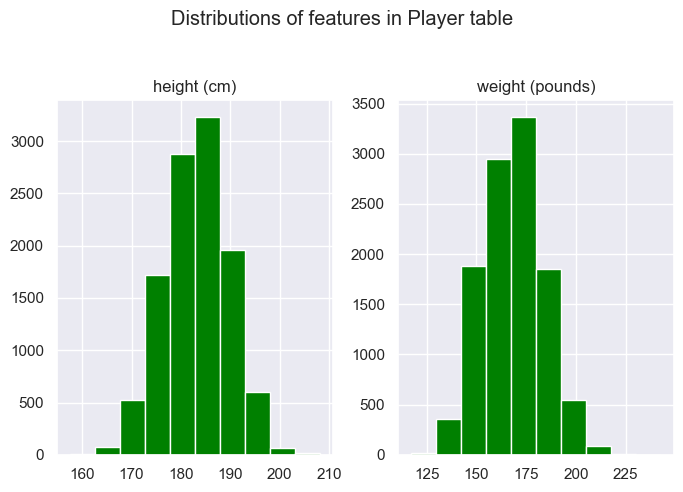

<IPython.core.display.Javascript object>

In [51]:
ax = pd.DataFrame.hist(
    player_df[["height", "weight"]].rename(
        columns={"height": "height (cm)", "weight": "weight (pounds)"}
    ),
    figsize=[7, 5],
    color="green",
)
plt.tight_layout()
plt.suptitle("Distributions of features in Player table")
plt.subplots_adjust(top=0.8)

Based on the visual observations and the summary statistics, there are no outliers that should be removed from the dataset.

In [52]:
team_attr_df = pd.read_sql_query(
    """
SELECT ta.*, t.team_long_name AS team_name
FROM Team_Attributes_temp ta
INNER JOIN Team t
ON t.team_api_id = ta.team_api_id
""",
    conn,
)
team_attr_df[
    [
        "buildUpPlaySpeed",
        "buildUpPlayPassing",
        "chanceCreationPassing",
        "chanceCreationCrossing",
        "chanceCreationShooting",
        "defencePressure",
        "defenceAggression",
        "defenceTeamWidth",
    ]
].describe()

buildUpPlaySpeed  buildUpPlayPassing  chanceCreationPassing  \
count       1458.000000         1458.000000            1458.000000   
mean          52.462277           48.490398              52.165295   
std           11.545869           10.896101              10.360793   
min           20.000000           20.000000              21.000000   
25%           45.000000           40.000000              46.000000   
50%           52.000000           50.000000              52.000000   
75%           62.000000           55.000000              59.000000   
max           80.000000           80.000000              80.000000   

       chanceCreationCrossing  chanceCreationShooting  defencePressure  \
count             1458.000000             1458.000000      1458.000000   
mean                53.731824               53.969136        46.017147   
std                 11.086796               10.327566        10.227225   
min                 20.000000               22.000000        23.000000   
25%                 47.000000               48.000000        39.000000   
50%                 53.000000               53.000000        45.000000   
75%                 62.000000               61.000000        51.000000   
max                 80.000000               80.000000        72.000000   

       defenceAggression  defenceTeamWidth  
count        1458.000000       1458.000000  
mean           49.251029         52.185871  
std             9.738028          9.574712  
min            24.000000         29.000000  
25%            44.000000         47.000000  
50%            48.000000         52.000000  
75%            55.000000         58.000000  
max            72.000000         73.000000

<IPython.core.display.Javascript object>

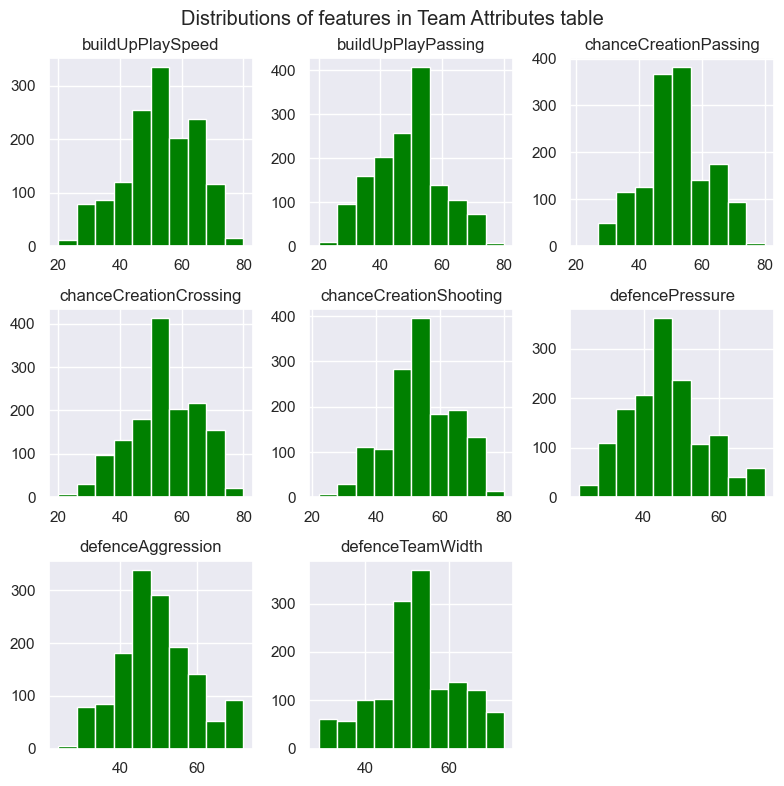

<IPython.core.display.Javascript object>

In [53]:
ax = pd.DataFrame.hist(
    team_attr_df[
        [
            "buildUpPlaySpeed",
            "buildUpPlayPassing",
            "chanceCreationPassing",
            "chanceCreationCrossing",
            "chanceCreationShooting",
            "defencePressure",
            "defenceAggression",
            "defenceTeamWidth",
        ]
    ],
    figsize=[8, 8],
    color="green",
)
plt.tight_layout()
plt.suptitle("Distributions of features in Team Attributes table")
plt.subplots_adjust(top=0.92)

Based on the visual observations and the summary statistics, there are no outliers that should be removed from the dataset.

In [54]:
player_overallrating_df[["overall_rating"]].describe().T

count       mean       std   min   25%   50%   75%   max
overall_rating  183142.0  68.600015  7.041139  33.0  64.0  69.0  73.0  94.0

<IPython.core.display.Javascript object>

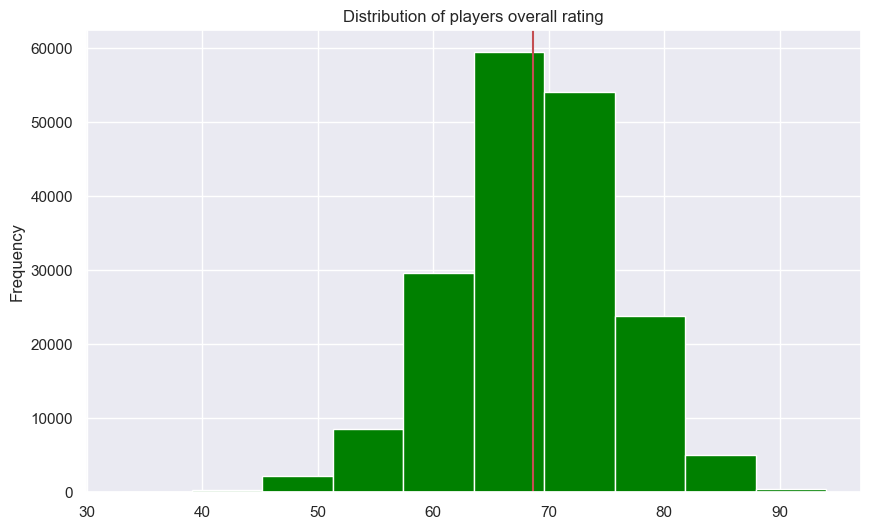

<IPython.core.display.Javascript object>

In [55]:
ax = player_overallrating_df["overall_rating"].plot.hist(color="green")
ax.axvline(x=np.mean(player_overallrating_df["overall_rating"]), c="r")
plt.title("Distribution of players overall rating")

Based on the visual observations and the summary statistics, there are no outliers that should be removed from the dataset.

In [56]:
cols = [
    "match_outcome",
    "last_match_outcome",
    "home_team_goal",
    "away_team_goal",
    "home_points_history",
    "away_points_history",
    "home_goals_history",
    "away_goals_history",
    "last_match_goal_difference",
]
matches_modelling_df[cols].describe()

last_match_outcome  home_team_goal  away_team_goal  \
count        16515.000000    16515.000000    16515.000000   
mean            -0.081865        1.569301        1.175901   
std              0.820639        1.310410        1.154631   
min             -1.000000        0.000000        0.000000   
25%             -1.000000        1.000000        0.000000   
50%              0.000000        1.000000        1.000000   
75%              1.000000        2.000000        2.000000   
max              1.000000       10.000000        8.000000   

       home_points_history  away_points_history  home_goals_history  \
count         16515.000000         16515.000000        16515.000000   
mean              8.000061             8.064668            1.364642   
std               2.889648             3.009200            0.548196   
min               0.000000             0.000000            0.000000   
25%               6.000000             6.000000            1.000000   
50%               8.000000             8.000000            1.300000   
75%              10.000000            10.000000            1.700000   
max              15.000000            15.000000            4.500000   

       away_goals_history  last_match_goal_difference  
count        16515.000000                16515.000000  
mean             1.388730                   -0.196972  
std              0.554668                    1.742859  
min              0.000000                  -10.000000  
25%              1.000000                   -1.000000  
50%              1.300000                    0.000000  
75%              1.700000                    1.000000  
max              4.300000                    9.000000

<IPython.core.display.Javascript object>

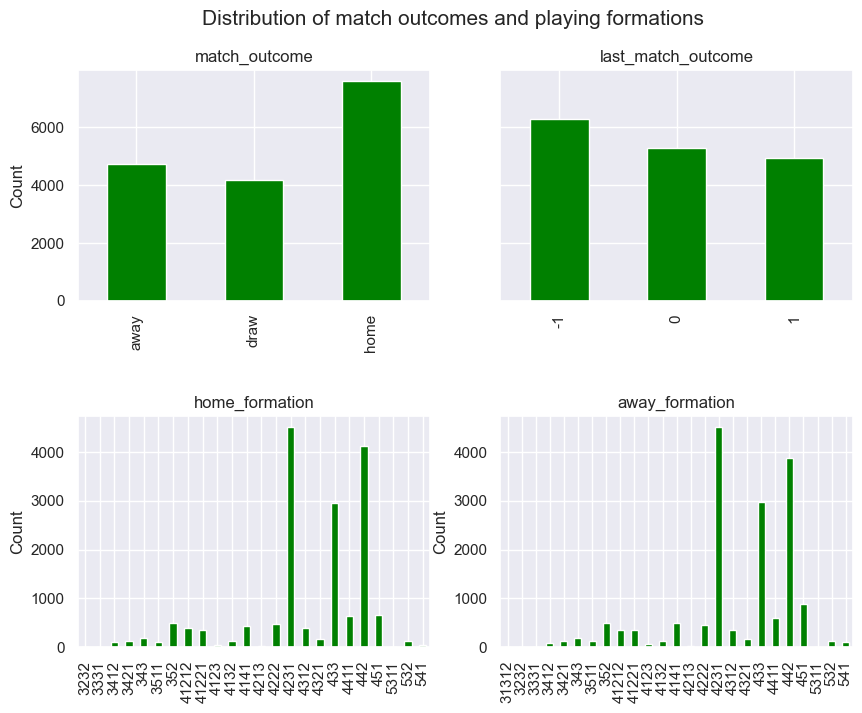

<IPython.core.display.Javascript object>

In [57]:
cols = [
    "match_outcome",
    "last_match_outcome",
    "home_formation",
    "away_formation",
]
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.suptitle(
    "Distribution of match outcomes and playing formations", fontsize=15, y=0.93
)
for n, col in enumerate(cols):
    ax = plt.subplot(3, 2, n + 1)

    matches_modelling_df[col].value_counts().sort_index().plot(
        kind="bar", ax=ax, title=col, color="green"
    )
    ax.set_ylabel("Count")
    if n % 2 != 0:
        ax.sharey(ax_prev)
    ax_prev = ax

Roughly half of the match outcomes are home wins, number of draws and away wins are quite on the same scale. The last match outcome shows the result of the last game the teams of the current match player against each other. '1' the current home team won, '0' draw and '-1- the current away team lost. The data shows that different outcomes are quite even. Win by the current away team '-1' is slightly higher than the other categories.

From the playing formation we can see that there is clearly three main tactics teams are using 4231, 442 and 433. These cover roughly 75% of all the matches.

Based on the visual observations and the summary statistics, there are no outliers that should be removed from the dataset.

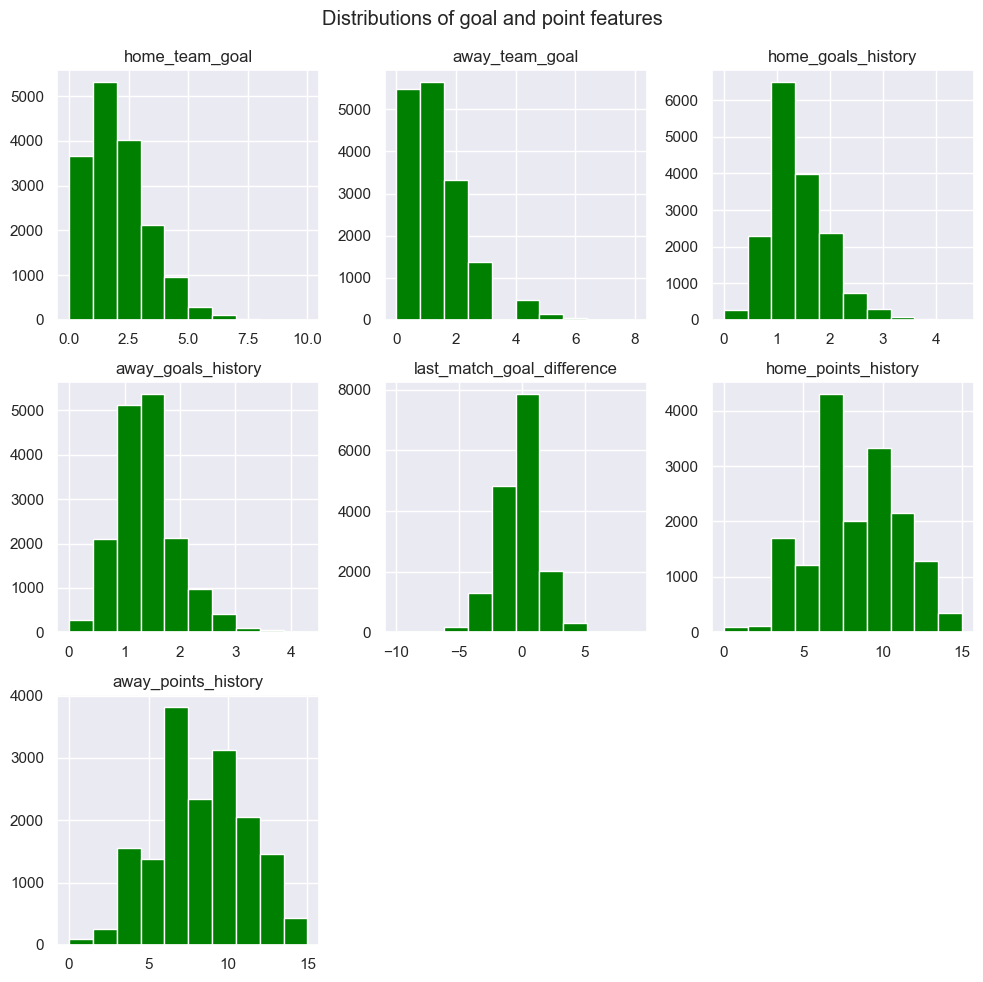

<IPython.core.display.Javascript object>

In [58]:
cols = [
    "home_team_goal",
    "away_team_goal",
    "home_goals_history",
    "away_goals_history",
    "last_match_goal_difference",
    "home_points_history",
    "away_points_history",
]

ax = pd.DataFrame.hist(
    matches_modelling_df[cols],
    figsize=[10, 10],
    color="green",
)
plt.tight_layout()
plt.suptitle("Distributions of goal and point features")
plt.subplots_adjust(top=0.92)

The *home points history* shows the total points the current home team has won from the last five games.

The *away points history* shows the total points the current away team has won from the last five games.

The *home goals history* shows the average number of goals of the home team from the last ten games.

The *away goals history* shows the average number of goals of the away team from the last ten games.

The *last match goal difference* shows the goal difference (home - away) from the last match the teams played against each other.

In all these historical features, if data is not available it will be zero.

The number of goals by home/away team are skewed to the right. The history features are a bit more centered. The goal differece is almost symmetricly distributed.

Based on the visual obervations and the summary statistics, there are no outliers that should be removed from the dataset.

### 3.2 Leagues and seasons

Next, the different seasons and leagues are investigated. The main questions to answer is how many seasons, leagues the dataset consist, and how many teams each league has. Finally, top scoring players and leagues are identified.

#### Seasons and number of matches per season

In [59]:
duckdb.query(
    """
    SELECT season, COUNT(*)
    FROM match_temp_df
    GROUP BY 1"""
).df()

season  count_star()
0  2008/2009          2451
1  2009/2010          2990
2  2010/2011          3018
3  2011/2012          2979
4  2012/2013          3019
5  2013/2014          3032
6  2014/2015          3325
7  2015/2016          3326

<IPython.core.display.Javascript object>

The dataset consist seasons from 2008 to 2016. For each season there is roughly 3000 matches in different league.

In [60]:
matches = duckdb.query(
    """
    SELECT l.league league, m.season, COUNT(*) number_of_matches
    FROM match_temp_df m
    INNER JOIN league_df l
    ON m.league_id = l.id
    GROUP BY 1,2
    ORDER BY 3 DESC"""
).df()

<IPython.core.display.Javascript object>

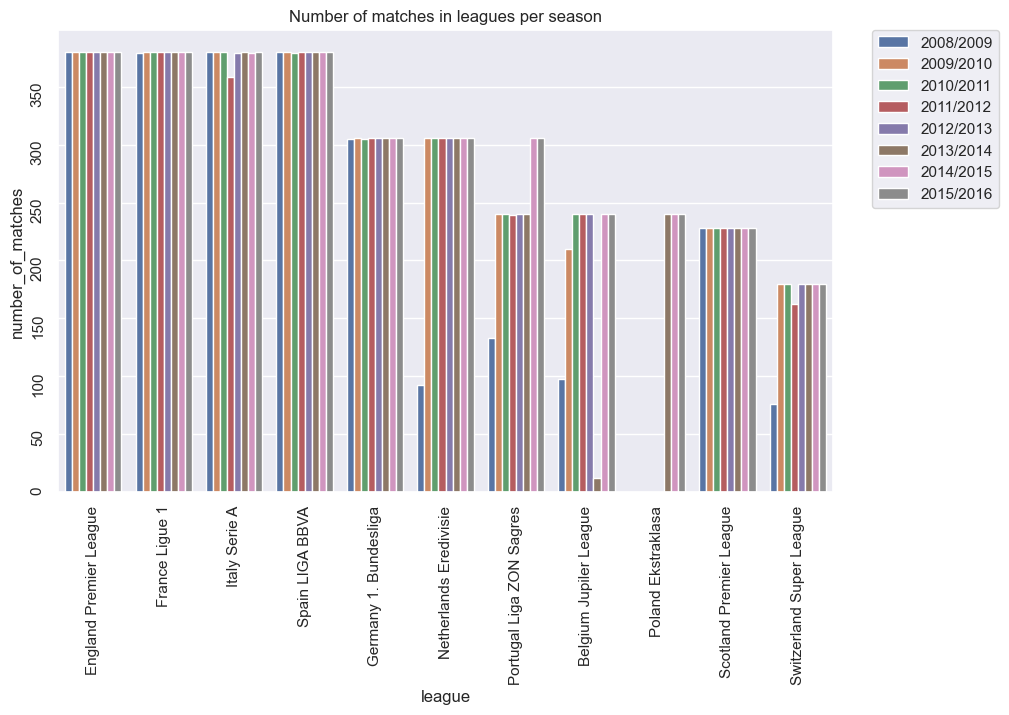

<IPython.core.display.Javascript object>

In [61]:
ax = sns.barplot(
    x=matches["league"], y=matches["number_of_matches"], hue=matches["season"]
)
ax.tick_params(labelrotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.title("Number of matches in leagues per season")

Some of the seasons are missing games. The England Premier League, France Ligue 1, Italy Serie A, Spain Liga BBVA and Germany 1. Bundesliga have almost all the matches in the dataset.

#### Number of teams in each leagues

In [62]:
teams = duckdb.query(
    """
    SELECT l.league AS league, m.season, COUNT(DISTINCT m.away_team_api_id) AS number_of_teams
    FROM league_df l
    INNER JOIN match_temp_df m
    ON l.id = m.league_id
    GROUP BY 1,2
    ORDER BY 1,2"""
).df()

<IPython.core.display.Javascript object>

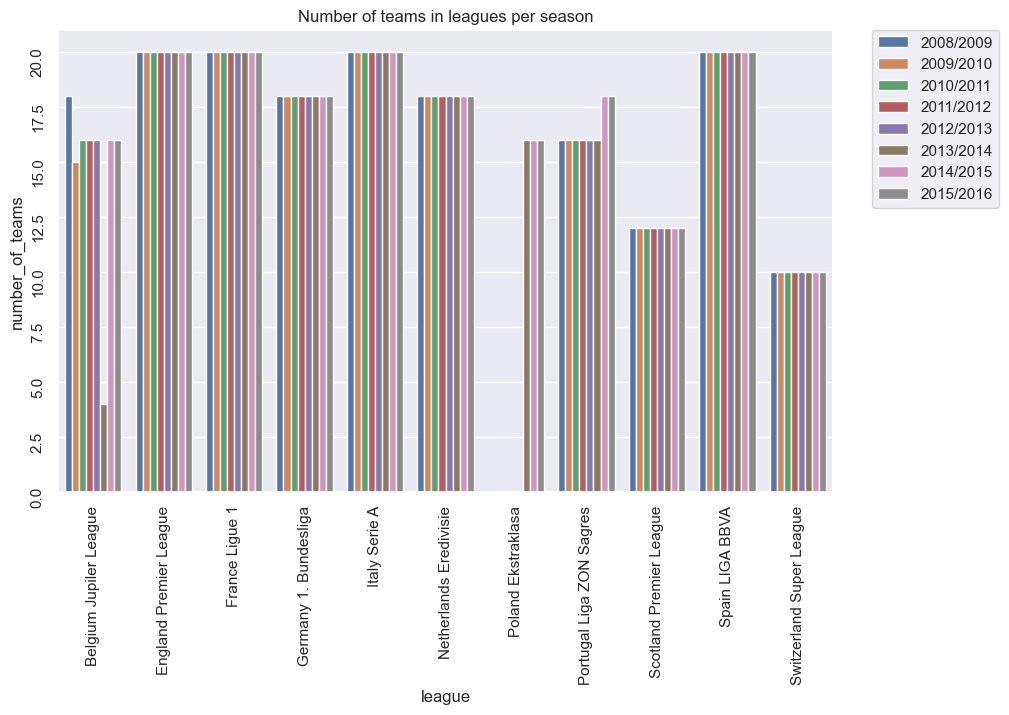

<IPython.core.display.Javascript object>

In [63]:
ax = sns.barplot(x=teams["league"], y=teams["number_of_teams"], hue=teams["season"])
ax.tick_params(labelrotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.title("Number of teams in leagues per season")

The main leagues have roughly 17-20 teams in every season. The smallest league is the Switzerland Super Legue with only ten teams.

#### Number of mathes in season per team

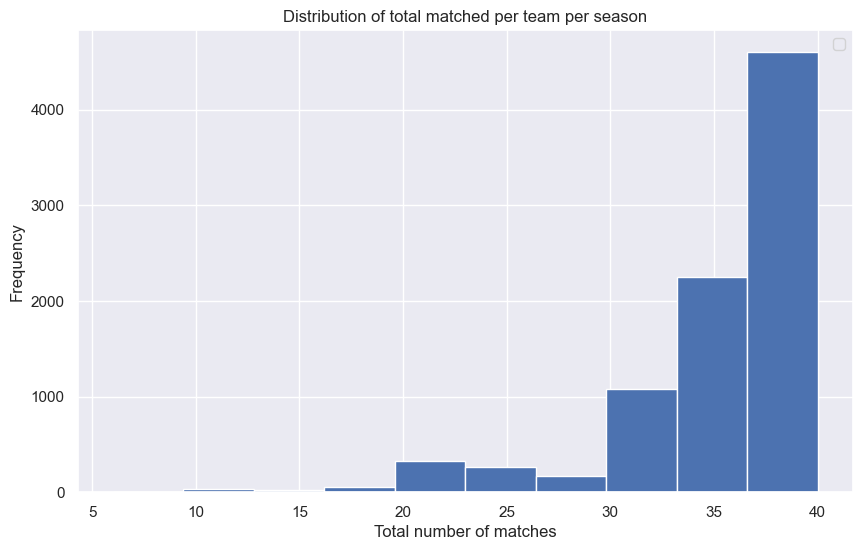

<IPython.core.display.Javascript object>

In [64]:
matches_per_team = duckdb.query(
    """
    WITH home AS (SELECT season, home_team_api_id AS team_id, COUNT(*) AS number_of_matches
    FROM match_temp_df
    GROUP BY 1,2),
    away AS (SELECT season, away_team_api_id AS team_id, COUNT(*) AS number_of_matches
    FROM match_temp_df
    GROUP BY 1,2)
    
    SELECT a.number_of_matches + h.number_of_matches AS total_matches
    FROM home h
    INNER JOIN away a
    ON h.team_id = a.team_id
    ORDER BY 1
    """
).df()
ax = matches_per_team.plot.hist(
    title="Distribution of total matched per team per season"
)
ax.set_xlabel("Total number of matches")
ax.legend([])

Majority of the teams will have 30 to 40 games per season.

#### Leagues from different countries

In [65]:
duckdb.query(
    """
    SELECT l.league AS league, c.name AS country, total_goals, avg_goals
    FROM league_df l
    INNER JOIN country_df c
    ON l.country_id = c.id
    INNER JOIN (
        SELECT 
            league_id, 
            SUM(home_team_goal+away_team_goal) as total_goals, 
            AVG(home_team_goal+away_team_goal) as avg_goals
        FROM match_temp_df
        GROUP BY league_id) tb
    ON tb.league_id = l.id
    ORDER BY 3 DESC
    """
).df()

league      country  total_goals  avg_goals
0            Spain LIGA BBVA        Spain       8409.0   2.767029
1     England Premier League      England       8240.0   2.710526
2              Italy Serie A        Italy       7892.0   2.616711
3             France Ligue 1       France       7425.0   2.443238
4      Germany 1. Bundesliga      Germany       7100.0   2.902698
5     Netherlands Eredivisie  Netherlands       6917.0   3.096240
6   Portugal Liga ZON Sagres     Portugal       4968.0   2.555556
7    Scotland Premier League     Scotland       4804.0   2.633772
8     Belgium Jupiler League      Belgium       4239.0   2.788816
9   Switzerland Super League  Switzerland       3876.0   2.940819
10        Poland Ekstraklasa       Poland       1897.0   2.634722

<IPython.core.display.Javascript object>

There are ten leagues from ten different countries in the dataset. The league with most goals in Spain and least goals in Switzerland which is also the smallest league. The average goals per match does not vary that much and is the highest in Netherlands Eredivisie.

#### Top scorers for each team.

Next, the detailed goal information is extracted for each match.

In [66]:
scores_df = duckdb.query(
    """
    SELECT p.player_name, tb3.goals, t.team_long_name, tb3.league_id, l.league
    FROM player_df p
    INNER JOIN 
        (SELECT player_id, team_id, league_id, COUNT(*) AS goals
        FROM 
            (SELECT
                league_id,
                regexp_extract(items, '\<comment\>([npo])\<\/comment\>',1) AS goal_type,
                regexp_extract(items, '\<team\>([0-9]+)\<\/team\>',1) AS team_id,
                regexp_extract(items, '\<player1\>([0-9]+)\<\/player1\>',1) AS player_id
            FROM (SELECT 
                    league_id, 
                    UNNEST(regexp_split_to_array(xml, '<\/value\>\<value\>')) AS items
                FROM goals_df
                ) tb1
            ) tb2
        WHERE NOT player_id = '' AND goal_type IN ('n','p')
        GROUP BY 1,2,3) tb3
    ON p.player_api_id = tb3.player_id
    INNER JOIN teams_df t
    ON tb3.team_id = t.team_api_id
    INNER JOIN league_df l
    ON tb3.league_id = l.id
    ORDER BY 2 DESC
    """
).df()

<IPython.core.display.Javascript object>

In [67]:
duckdb.query(
    """
    SELECT s1.player_name, s1.team_long_name, s1.goals
    FROM scores_df s1
    INNER JOIN (
        SELECT team_long_name, league, MAX(goals) AS goals
        FROM scores_df
        GROUP BY 1, 2
    ) m_tb
    ON s1.team_long_name = m_tb.team_long_name AND s1.goals = m_tb.goals
    """
)


┌───────────────────┬───────────────────┬───────┐
│    player_name    │  team_long_name   │ goals │
│      varchar      │      varchar      │ int64 │
├───────────────────┼───────────────────┼───────┤
│ Lionel Messi      │ FC Barcelona      │   212 │
│ Cristiano Ronaldo │ Real Madrid CF    │   176 │
│ Wayne Rooney      │ Manchester United │   105 │
│ Edinson Cavani    │ Napoli            │    77 │
│ Frank Lampard     │ Chelsea           │    76 │
│ Mario Gomez       │ FC Bayern Munich  │    75 │
│ Alvaro Negredo    │ Sevilla FC        │    70 │
│ Luis Suarez       │ Liverpool         │    69 │
│ Francesco Totti   │ Roma              │    69 │
│ Robin van Persie  │ Arsenal           │    68 │
│      ·            │    ·              │     · │
│      ·            │    ·              │     · │
│      ·            │    ·              │     · │
│ Alex Schalk       │ Go Ahead Eagles   │     3 │
│ Artjoms Rudnevs   │ Lech Poznań       │     3 │
│ Mart Lieder       │ FC Dordrecht      │     2 │


<IPython.core.display.Javascript object>

The difference between the top scoring player and least scoring player is quite large. The top10 scorers are somewhat familiar names. The top2 players standout from the rest. 

#### Top scorers for each league.

In [68]:
duckdb.query(
    """
    SELECT s1.player_name, s1.league, s1.goals
    FROM scores_df s1
    INNER JOIN (
        SELECT league, MAX(goals) AS goals
        FROM scores_df
        GROUP BY 1
    ) m_tb
    ON s1.league = m_tb.league AND s1.goals = m_tb.goals
    """
)

┌────────────────────┬──────────────────────────┬───────┐
│    player_name     │          league          │ goals │
│      varchar       │         varchar          │ int64 │
├────────────────────┼──────────────────────────┼───────┤
│ Lionel Messi       │ Spain LIGA BBVA          │   212 │
│ Antonio Di Natale  │ Italy Serie A            │   131 │
│ Wayne Rooney       │ England Premier League   │   105 │
│ Stefan Kiessling   │ Germany 1. Bundesliga    │    95 │
│ Zlatan Ibrahimovic │ France Ligue 1           │    56 │
│ Luuk de Jong       │ Netherlands Eredivisie   │    17 │
│ Guillaume Hoarau   │ Switzerland Super League │    17 │
│ Kenny Miller       │ Scotland Premier League  │     7 │
│ Artjoms Rudnevs    │ Poland Ekstraklasa       │     3 │
└────────────────────┴──────────────────────────┴───────┘

<IPython.core.display.Javascript object>

The top scorer for each league is shown here. As can be seen there is some difference in the quality of the leagues top scorers.

### 3.3 Winning and goal making

Next the winning rates, wins, and goal making are studied. Then in the following subsections, the relationship of winning and goal making to the other relevant features are studied. The main research questions are:
- Can we identify a pattern for teams with higher winning rate?
- Can we identify a pattern for teams with higher number of goals?

First, the winning rates are calculated for each team in different seasons.

In [69]:
winning_rate_seasons_df = pd.read_sql_query(
    """
    WITH home AS (
    SELECT th.team_long_name AS team_name, 
        m.season, AVG(m.home_win) AS home_win, 
        AVG(m.away_win) AS home_lose, AVG(m.draw) AS home_draw
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.home_team_api_id = th.team_api_id
    GROUP BY 1, 2)
    
    SELECT 
        th.team_long_name AS team_name,
        th.team_api_id,
        m.season, 
        h.home_win, 
        h.home_lose, 
        h.home_draw, 
        AVG(m.home_win) AS away_lose, 
        AVG(m.away_win) AS away_win, 
        AVG(m.draw) AS away_draw,
        (AVG(m.away_win) + h.home_win)*0.5 AS total_winning_rate, 
        (AVG(m.home_win) + h.home_lose)*0.5 AS total_losing_rate, 
        (AVG(m.draw) + h.home_draw)*0.5 AS total_draw
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.away_team_api_id = th.team_api_id
    INNER JOIN home h
    ON h.team_name = th.team_long_name AND h.season = m.season
    GROUP BY 1, 2, 3 """,
    conn,
)

<IPython.core.display.Javascript object>

In [70]:
winning_rate_seasons_df.set_index(["team_name", "season"], inplace=True)

<IPython.core.display.Javascript object>

In [71]:
winning_rate_seasons_df.head()

team_api_id  home_win  home_lose  home_draw  \
team_name            season                                                   
1. FC Kaiserslautern 2010/2011         8350  0.352941   0.294118   0.352941   
                     2011/2012         8350  0.117647   0.588235   0.294118   
1. FC Köln           2008/2009         8722  0.250000   0.500000   0.250000   
                     2009/2010         8722  0.176471   0.470588   0.352941   
                     2010/2011         8722  0.647059   0.235294   0.117647   

                                away_lose  away_win  away_draw  \
team_name            season                                      
1. FC Kaiserslautern 2010/2011   0.529412  0.411765   0.058824   
                     2011/2012   0.529412  0.117647   0.352941   
1. FC Köln           2008/2009   0.529412  0.411765   0.058824   
                     2009/2010   0.352941  0.352941   0.294118   
                     2010/2011   0.705882  0.117647   0.176471   

                                total_winning_rate  total_losing_rate  \
team_name            season                                             
1. FC Kaiserslautern 2010/2011            0.382353           0.411765   
                     2011/2012            0.117647           0.558824   
1. FC Köln           2008/2009            0.330882           0.514706   
                     2009/2010            0.264706           0.411765   
                     2010/2011            0.382353           0.470588   

                                total_draw  
team_name            season                 
1. FC Kaiserslautern 2010/2011    0.205882  
                     2011/2012    0.323529  
1. FC Köln           2008/2009    0.154412  
                     2009/2010    0.323529  
                     2010/2011    0.147059

<IPython.core.display.Javascript object>

#### Wins and Winning rate per season of each team

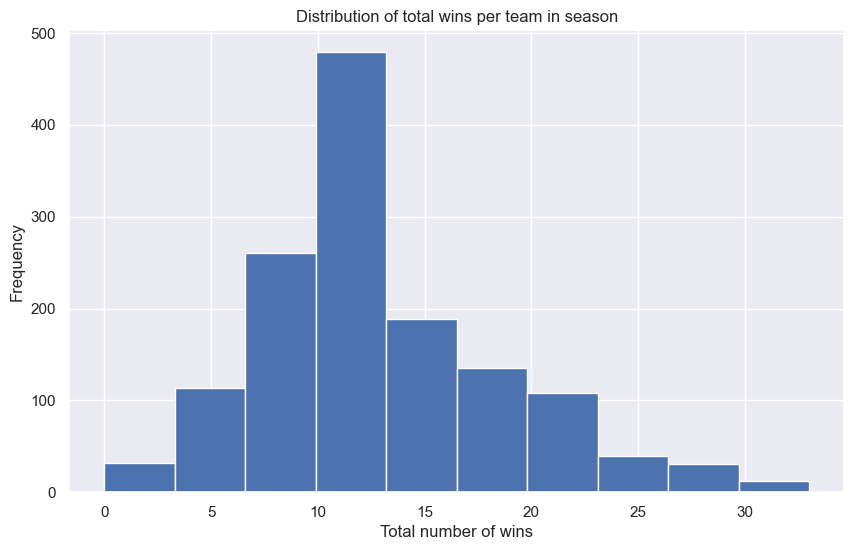

<IPython.core.display.Javascript object>

In [72]:
total_wins = (
    match_temp_df.groupby(["home_team_api_id", "season"])["home_win"].sum()
    + match_temp_df.groupby(["away_team_api_id", "season"])["away_win"].sum()
)
ax = total_wins.plot.hist(title="Distribution of total wins per team in season")
ax.set_xlabel("Total number of wins")

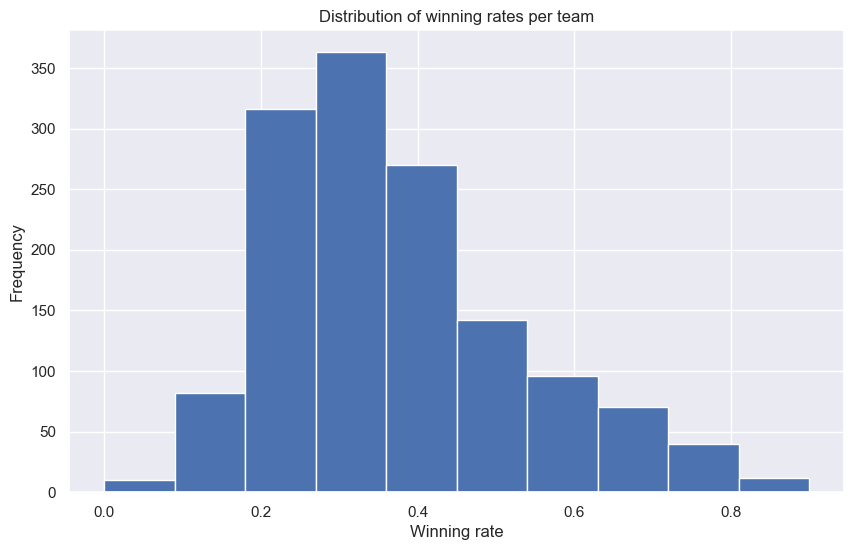

<IPython.core.display.Javascript object>

In [74]:
ax = winning_rate_seasons_df["total_winning_rate"].plot.hist(
    title="Distribution of winning rates per team"
)
ax.set_xlabel("Winning rate")

Both total number of wins and winning rate are almost normally distributed. Slightly skewed to the right.

#### Goal making

Then the average number of goals is calculated for each team in different seasons.

In [75]:
goals_seasons_df = pd.read_sql_query(
    """
    WITH home AS (
    SELECT th.team_long_name AS team_name, 
        m.season, 
        AVG(m.home_team_goal) AS home_average_goals
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.home_team_api_id = th.team_api_id
    GROUP BY 1, 2)
    
    SELECT 
        th.team_long_name AS team_name, 
        m.season, 
        h.home_average_goals, 
        AVG(m.away_team_goal) AS away_average_goals, 
        (AVG(m.away_team_goal) + h.home_average_goals)*0.5 AS total_mean_goals
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.away_team_api_id = th.team_api_id
    INNER JOIN home h
    ON h.team_name = th.team_long_name AND h.season = m.season
    GROUP BY 1, 2 """,
    conn,
)

<IPython.core.display.Javascript object>

In [76]:
goals_seasons_df.set_index(["team_name", "season"], inplace=True)

<IPython.core.display.Javascript object>

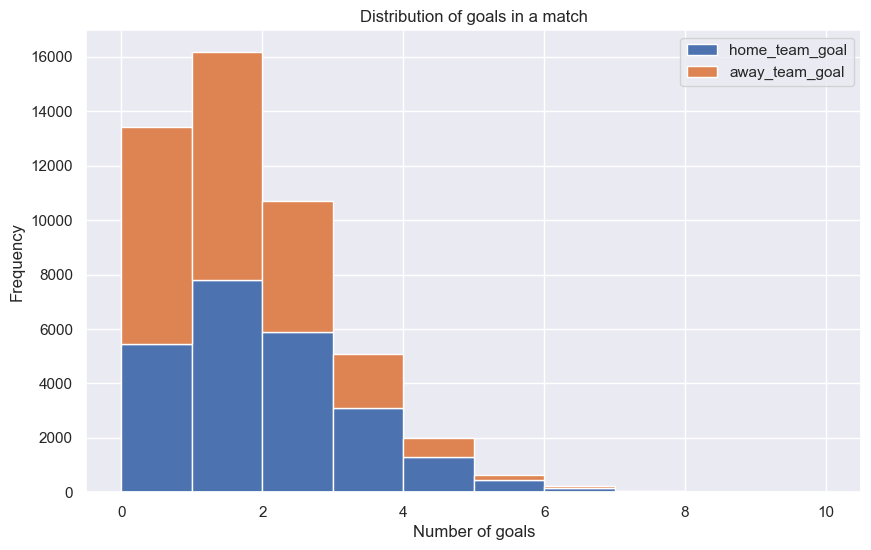

<IPython.core.display.Javascript object>

In [77]:
ax = match_temp_df[["home_team_goal", "away_team_goal"]].plot.hist(
    stacked=True, title="Distribution of goals in a match"
)
ax.set_xlabel("Number of goals")

The number of goals seems to be close to the Poisson distribution.

In [78]:
goals_seasons_df["total_mean_goals"].describe()

count    1401.000000
mean        1.362976
std         0.435424
min         0.433333
25%         1.052632
50%         1.264706
75%         1.578947
max         3.184211
Name: total_mean_goals, dtype: float64

<IPython.core.display.Javascript object>

### 3.4 Team attributes

Here the impact of team attributes to the winning rate and goal making is studied.

First, all the information is merged with the team attributes in different seasons.

In [79]:
numerical_columns = [
    "buildUpPlaySpeed",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]

team_attr_season_df = team_attr_df.groupby(["team_name", "season"], as_index=False)[
    numerical_columns
].mean()
team_attr_season_df.set_index(["team_name", "season"], inplace=True)

<IPython.core.display.Javascript object>

In [80]:
winner_attributes_season_df = winning_rate_seasons_df[["total_winning_rate"]].merge(
    team_attr_season_df[numerical_columns],
    left_index=True,
    right_index=True,
    how="inner",
)
winner_attributes_season_df = winner_attributes_season_df.merge(
    goals_seasons_df["total_mean_goals"],
    left_index=True,
    right_index=True,
    how="inner",
)

<IPython.core.display.Javascript object>

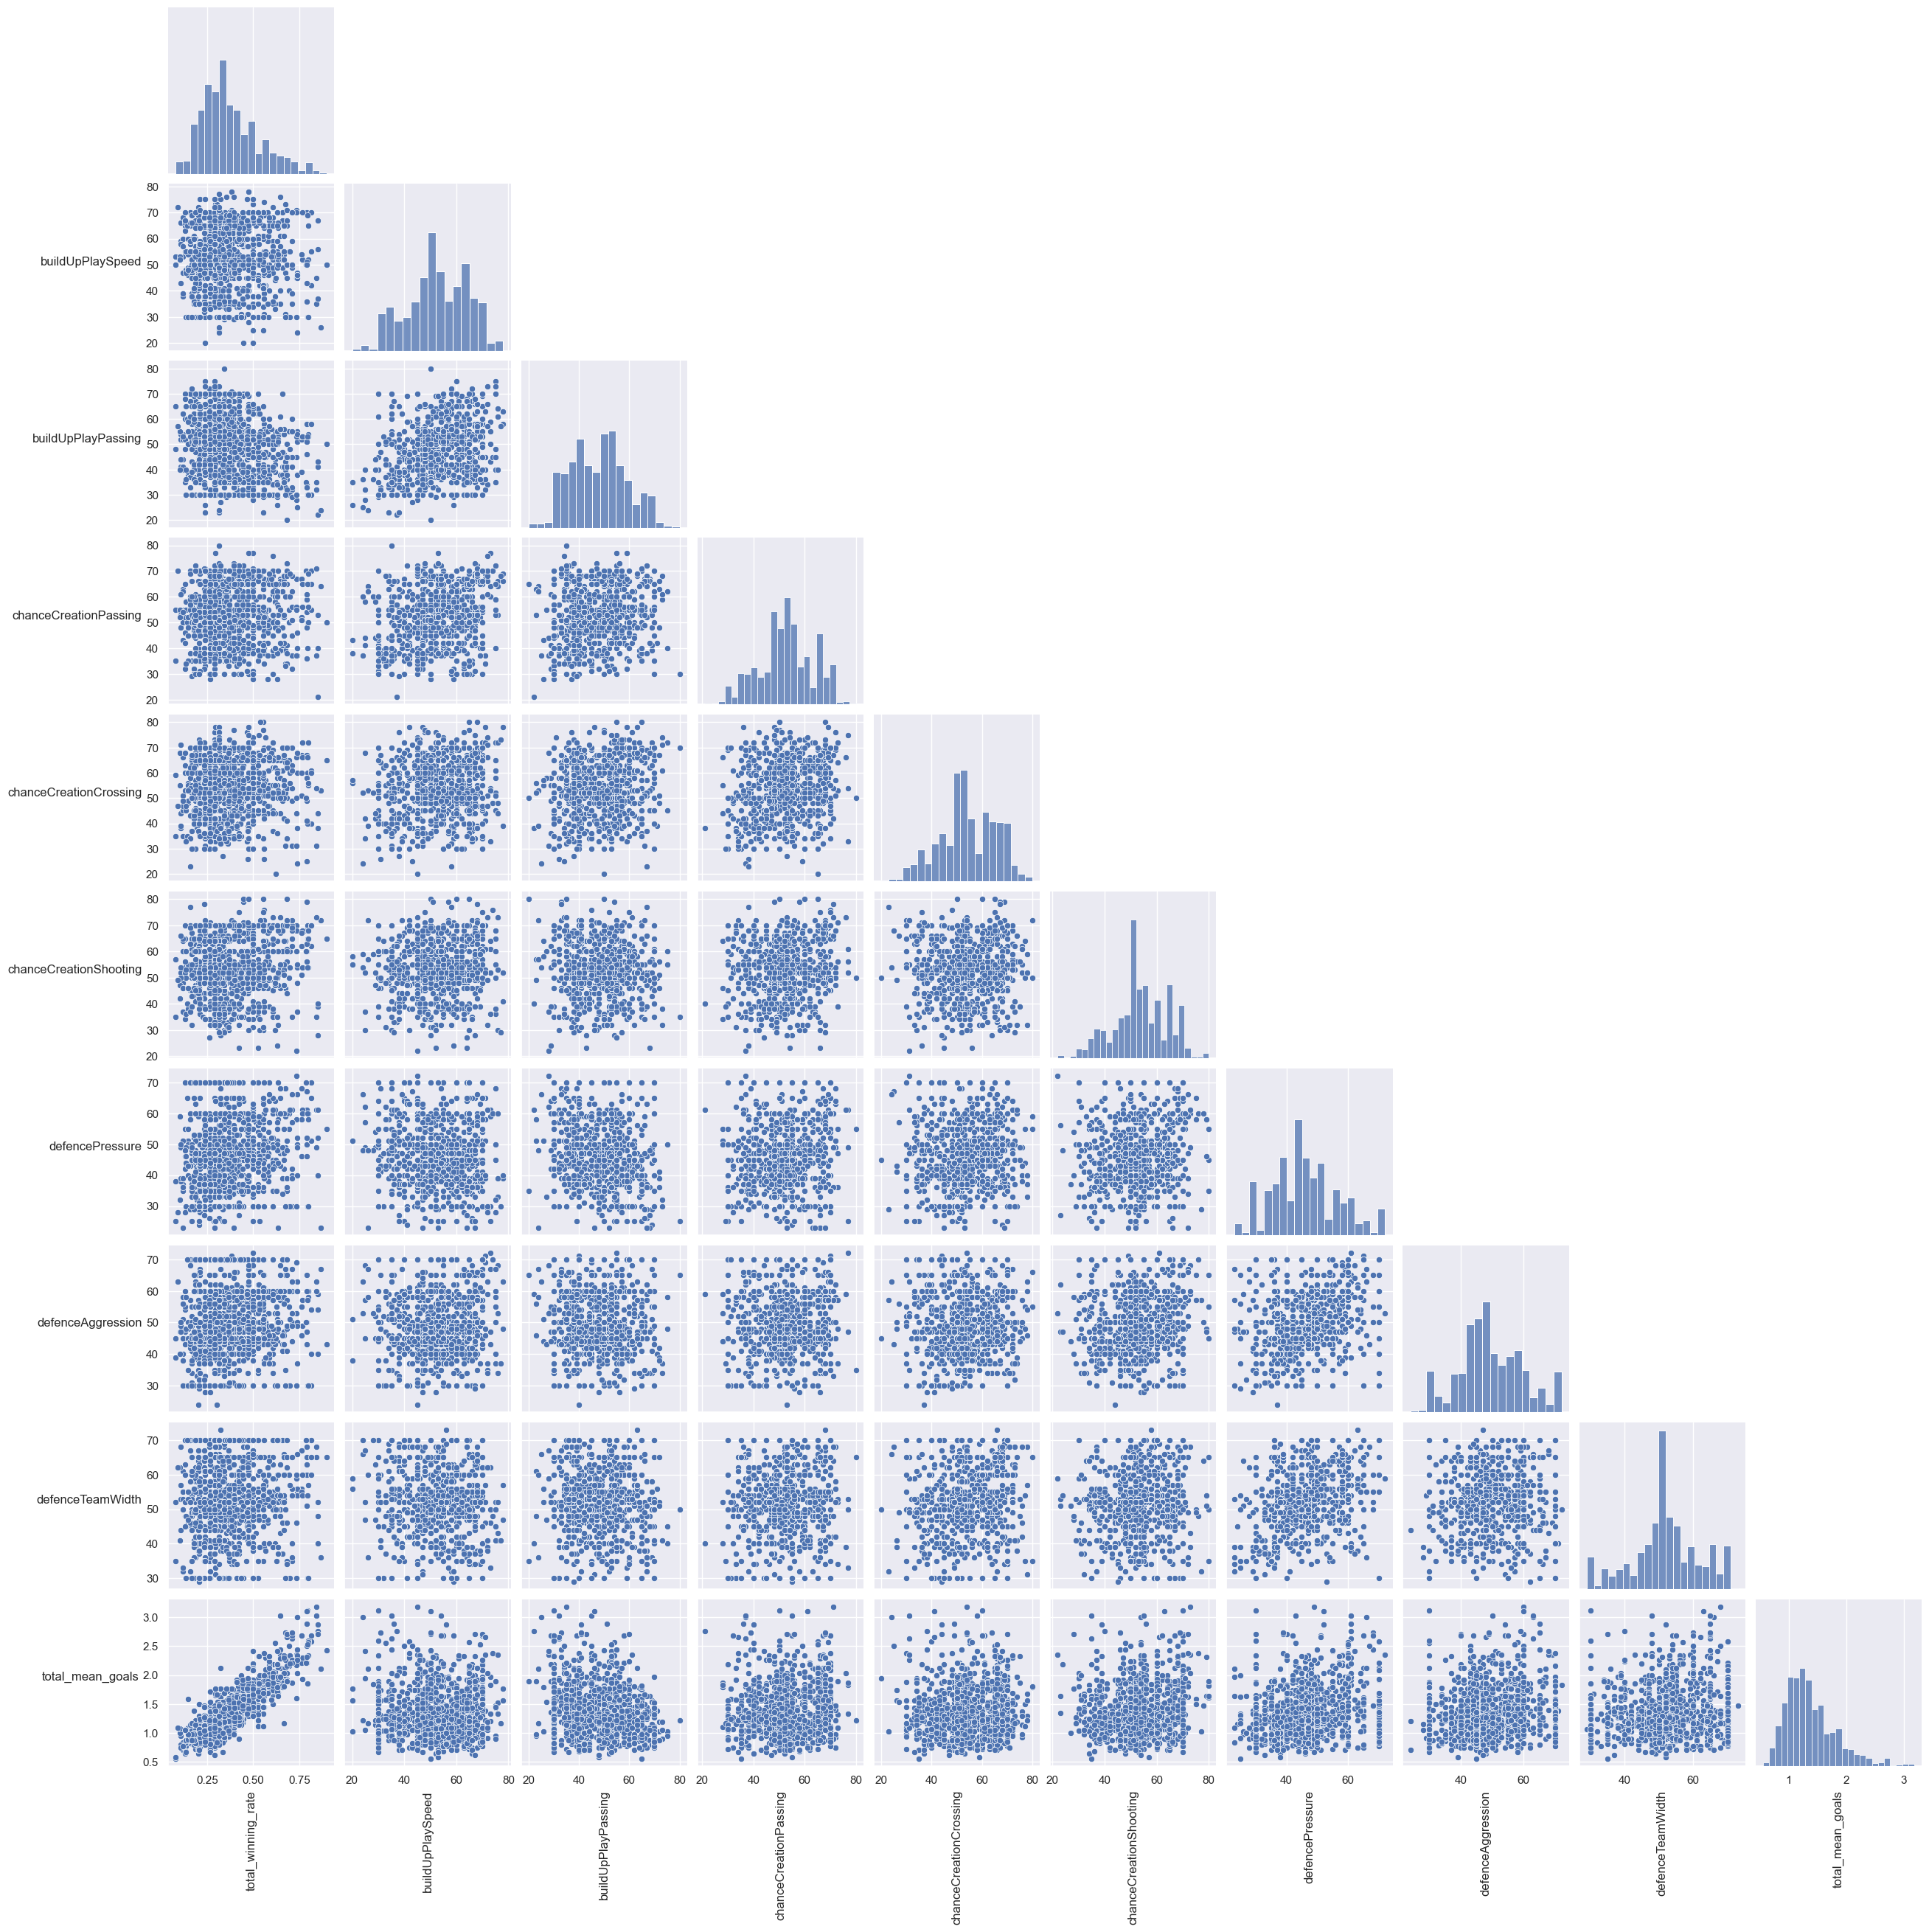

<IPython.core.display.Javascript object>

In [81]:
sns.set_context(rc={"axes.labelsize": 20, "figure.figsize": (8, 8)})
g = sns.pairplot(winner_attributes_season_df, corner=True)
for ax in g.axes.flatten():
    if ax:
        ax.set_xlabel(ax.get_xlabel(), rotation=90)
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        ax.yaxis.get_label().set_horizontalalignment("right")

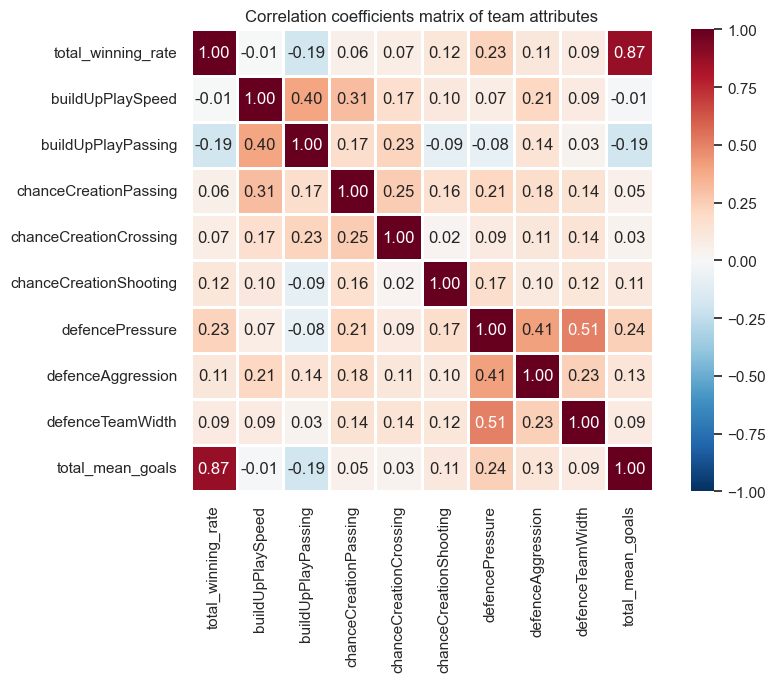

<IPython.core.display.Javascript object>

In [82]:
sns.set(rc={"figure.figsize": (10, 6)})
plt.title(
    "Correlation coefficients matrix of team attributes",
)
ax = sns.heatmap(
    winner_attributes_season_df.corr(),
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)

The correlation matrix shows it clearly that there is no strong correlation or only small correlation between the goal making or winnig rate and team attributes.

### 3.5 Player overall rating

Here, the impact the player overall rating on match outcome is investigated.

In [83]:
home_players = [f"home_player_{x}_rating" for x in range(1, 12)]
away_players = [f"away_player_{x}_rating" for x in range(1, 12)]

<IPython.core.display.Javascript object>

<Figure size 800x1000 with 0 Axes>

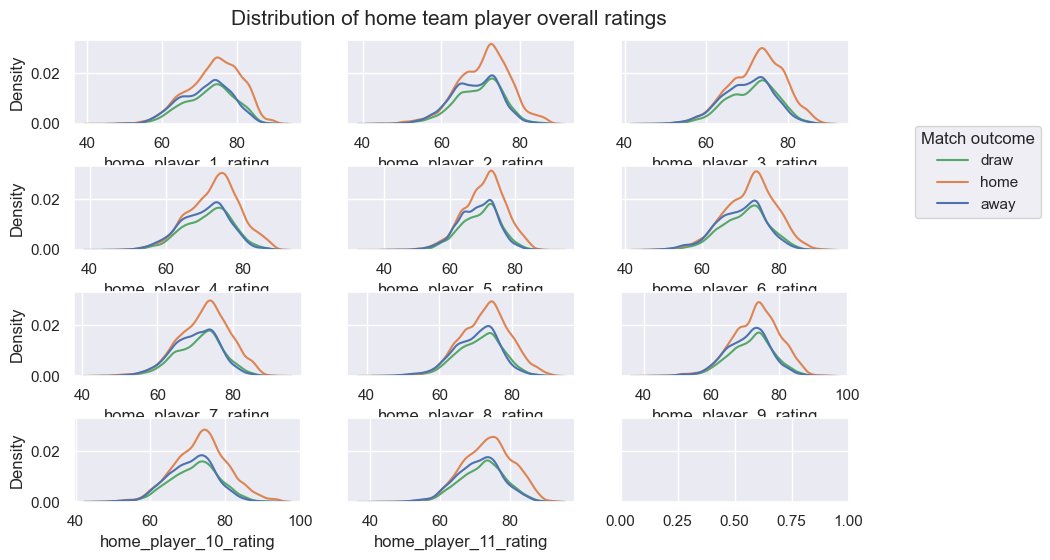

<IPython.core.display.Javascript object>

In [84]:
plt.figure(figsize=(8, 10))
fig, axes = plt.subplots(4, 3, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle(
    "Distribution of home team player overall ratings",
    fontsize=15,
    y=0.93,
)
for col, ax in zip(home_players, axes.flat):
    sns.kdeplot(
        data=matches_modelling_df, x=col, hue="match_outcome", ax=ax, legend=False
    )
plt.figlegend(
    title="Match outcome", labels=["draw", "home", "away"], bbox_to_anchor=(1.1, 0.75)
)

In [85]:
matches_modelling_df.groupby("match_outcome")[home_players].mean()

home_player_1_rating  home_player_2_rating  \
match_outcome                                               
away                      71.760414             68.564390   
draw                      72.758034             69.555396   
home                      74.003808             70.874212   

               home_player_3_rating  home_player_4_rating  \
match_outcome                                               
away                      70.114401             70.002326   
draw                      71.266906             71.019904   
home                      72.516807             72.566176   

               home_player_5_rating  home_player_6_rating  \
match_outcome                                               
away                      68.544090             70.041869   
draw                      69.452998             71.068106   
home                      70.762999             72.588892   

               home_player_7_rating  home_player_8_rating  \
match_outcome                                               
away                      70.181222             70.196659   
draw                      71.206475             71.133094   
home                      72.622243             72.747505   

               home_player_9_rating  home_player_10_rating  \
match_outcome                                                
away                      70.863185              71.103616   
draw                      71.743405              72.085612   
home                      73.307248              73.728072   

               home_player_11_rating  
match_outcome                         
away                       71.208501  
draw                       72.197122  
home                       73.846770

<IPython.core.display.Javascript object>

Based on the figures and mean values, there is small difference between the distribution of home team player overall rating for matches where home team won and lost. The mean value for the ratings is slightly higher in matches where home team won, but the difference is small.

<Figure size 800x1000 with 0 Axes>

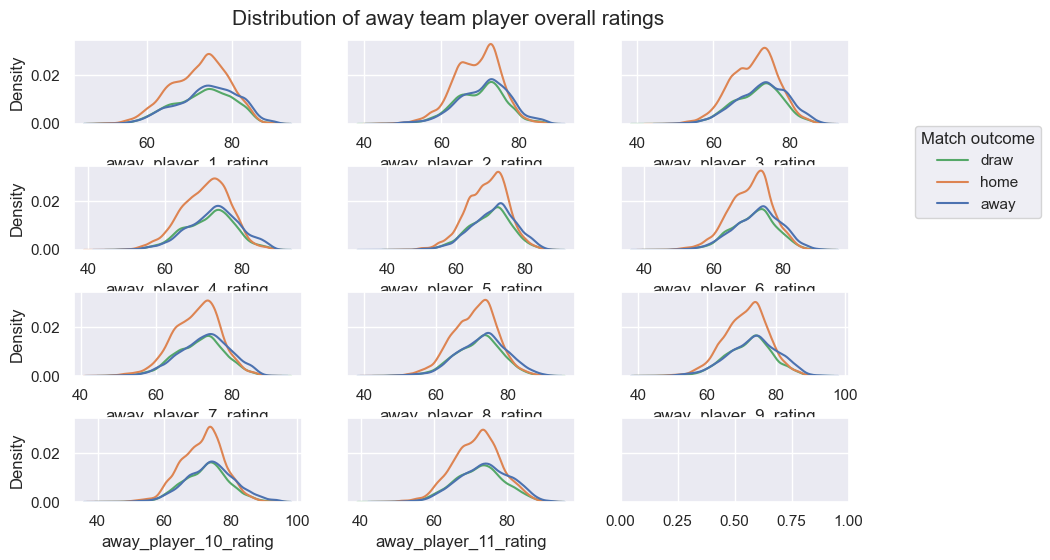

<IPython.core.display.Javascript object>

In [86]:
plt.figure(figsize=(8, 10))
fig, axes = plt.subplots(4, 3, sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle(
    "Distribution of away team player overall ratings",
    fontsize=15,
    y=0.93,
)
for col, ax in zip(away_players, axes.flat):
    sns.kdeplot(
        data=matches_modelling_df, x=col, hue="match_outcome", ax=ax, legend=False
    )
plt.figlegend(
    title="Match outcome", labels=["draw", "home", "away"], bbox_to_anchor=(1.1, 0.75)
)

In [87]:
matches_modelling_df.groupby("match_outcome")[away_players].mean()

away_player_1_rating  away_player_2_rating  \
match_outcome                                               
away                      74.245506             70.995136   
draw                      73.151319             69.864748   
home                      72.303046             69.130515   

               away_player_3_rating  away_player_4_rating  \
match_outcome                                               
away                      72.762741             72.713259   
draw                      71.577698             71.508393   
home                      70.697610             70.537159   

               away_player_5_rating  away_player_6_rating  \
match_outcome                                               
away                      70.928526             72.655107   
draw                      69.792566             71.386571   
home                      69.018251             70.561187   

               away_player_7_rating  away_player_8_rating  \
match_outcome                                               
away                      72.838867             72.832311   
draw                      71.496403             71.636451   
home                      70.653099             70.686318   

               away_player_9_rating  away_player_10_rating  \
match_outcome                                                
away                      73.385494              73.929372   
draw                      72.179376              72.494245   
home                      71.321429              71.552258   

               away_player_11_rating  
match_outcome                         
away                       73.949461  
draw                       72.538129  
home                       71.891938

<IPython.core.display.Javascript object>

Based on the figures and mean values, there is small difference between the distribution of away team player overall rating for matches where away team won and lost. The difference is even smaller than for the home teams.

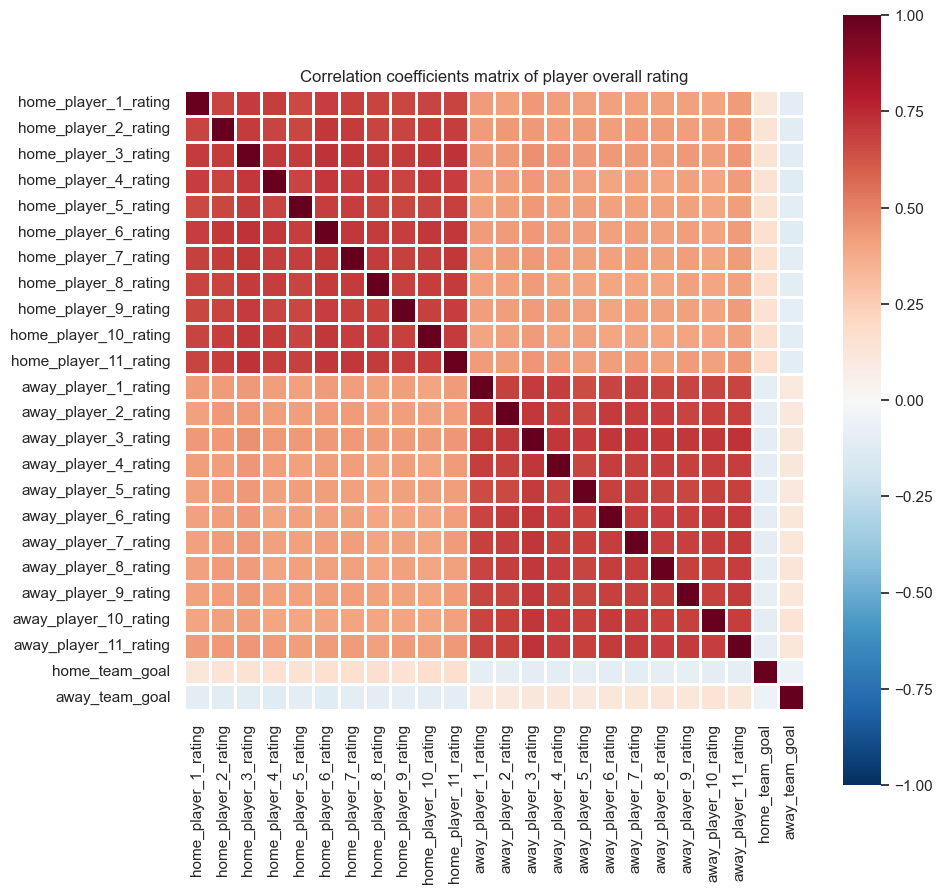

<IPython.core.display.Javascript object>

In [88]:
cols = home_players + away_players + ["home_team_goal", "away_team_goal"]
plt.figure(figsize=(10, 10))
plt.title(
    "Correlation coefficients matrix of player overall rating",
)
ax = sns.heatmap(
    matches_modelling_df[cols].corr(),
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=False,
)

There is high or medicore correlation between player ratings which will be dealt later when the prediction models are built. However, the ratings are not correlating with match goals.

### 3.6 Playing tactics

Here, the different playing tactics or formations are investigated. How the formation affect to the result of each match? The formation features are defined based on the player coordinates given for each match.

In [89]:
home_formation = matches_modelling_df.groupby("home_formation").agg(
    count=("league_id", "count"),
    wins=("home_win", "sum"),
    lose=("away_win", "sum"),
    draw=("draw", "sum"),
    mean_goals=("home_team_goal", "mean"),
    mean_goals_against=("away_team_goal", "mean"),
)
away_formation = matches_modelling_df.groupby("away_formation").agg(
    count=("league_id", "count"),
    wins=("away_win", "sum"),
    lose=("home_win", "sum"),
    draw=("draw", "sum"),
    mean_goals=("away_team_goal", "mean"),
    mean_goals_against=("home_team_goal", "mean"),
)
formation = home_formation.add(away_formation, fill_value=0)
formation["mean_goals"] = formation["mean_goals"] / 2
formation["mean_goals_against"] = formation["mean_goals_against"] / 2
formation["winning_rate"] = formation["wins"] / formation["count"]
formation["losing_rate"] = formation["lose"] / formation["count"]
formation["draw_rate"] = formation["draw"] / formation["count"]
formation = formation.sort_values(by="count", ascending=False)

<IPython.core.display.Javascript object>

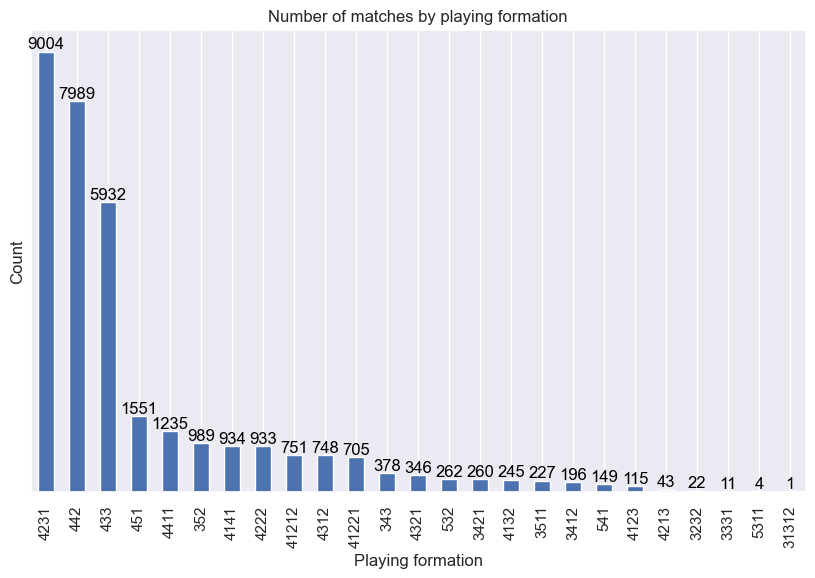

<IPython.core.display.Javascript object>

In [90]:
ax = formation["count"].plot.bar(title="Number of matches by playing formation")
ax.set_yticks([])
ax.set_ylabel("Count")
ax.set_xlabel("Playing formation")
for container in ax.containers:
    ax.bar_label(container, padding=0, color="black")

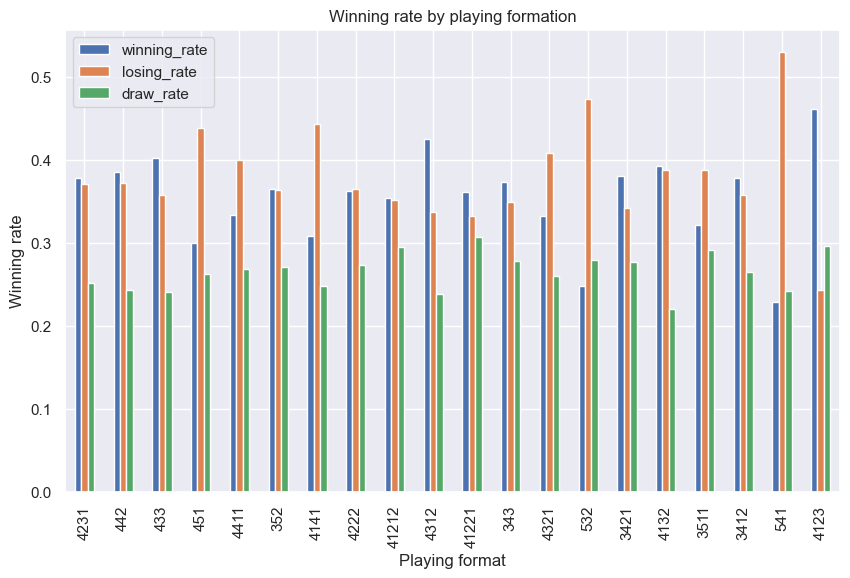

<IPython.core.display.Javascript object>

In [91]:
ax = formation.loc[
    ~formation.index.isin(["31312", "5311", "3331", "3232", "4213"]),
    ["winning_rate", "losing_rate", "draw_rate"],
].plot.bar(title="Winning rate by playing formation")
# ax.set_yticks([])
ax.set_ylabel("Winning rate")
ax.set_xlabel("Playing format")

There is some variation in the wining rates. From the top3 most used tactics 4231, 442 and 433, the 433 seems to have slightly higher winning rate and lower losing rate compared to the other two.

The 433 formation has the best performance compared to other formations excluding 4123 which has the highest winning rate and lowest losing rate. However, it has much less matches played and this can affect also to the result.

The formations 31312, 5311, 3331, 3232, and 4213 excluded from the analysis as they all have much less matches played than the others. All have under 50 matches.

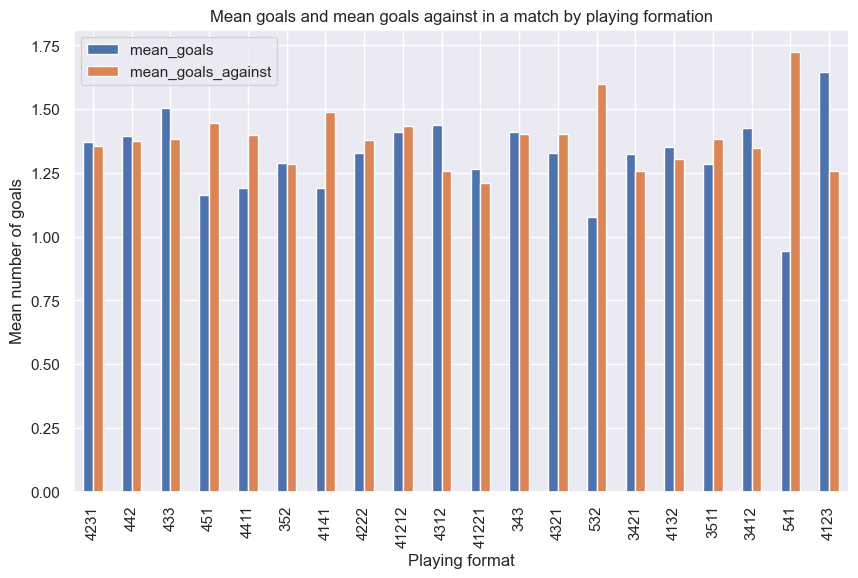

<IPython.core.display.Javascript object>

In [92]:
ax = formation.loc[
    ~formation.index.isin(["31312", "5311", "3331", "3232", "4213"]),
    ["mean_goals", "mean_goals_against"],
].plot.bar(title="Mean goals and mean goals against in a match by playing formation")
ax.set_ylabel("Mean number of goals")
ax.set_xlabel("Playing format")

There is no clear difference in mean goals or mean goals against. From the top3 most used tactics 4231, 442 and 433, the 433 seem to have slightly higher mean goals. In addition, those teams have got less goals against.

In here also, the 433 formation has the highest mean goals compared to other formations excluding 4123 which has the highest mean goals.

### 3.7 Previous performance

Next, the impact of historical features to the winning and goal making is investigated. The questions are:
- Does the outcome of the last match team played against each other affect to the outcome of the current match?
- Does the goal difference of the last match team played against each other affect to the outcome of the current match?
- Do the points from the last five games affect to the match outcome?
- Does the mean number of goals from the last ten games affect to the match outcome?


#### Last match outcome

In [93]:
last_result = matches_modelling_df.groupby("last_match_outcome").agg(
    count=("league_id", "count"),
    home_win=("home_win", "sum"),
    away_win=("away_win", "sum"),
    draw=("draw", "sum"),
    home_mean_goals=("home_team_goal", "mean"),
    away_mean_goals=("away_team_goal", "mean"),
)

last_result["home_team_winning_rate"] = last_result["home_win"] / last_result["count"]
last_result["away_team_winning_rate"] = last_result["away_win"] / last_result["count"]
last_result["draw_rate"] = last_result["draw"] / last_result["count"]
last_result = last_result.sort_values(by="count", ascending=False)
last_result.index = ["away_team_won", "draw", "home_team_won"]

<IPython.core.display.Javascript object>

In [94]:
last_result

count  home_win  away_win  draw  home_mean_goals  \
away_team_won   6292      2440      2230  1622         1.385728   
draw            5283      2445      1488  1350         1.559720   
home_team_won   4940      2731      1011  1198         1.813360   

               away_mean_goals  home_team_winning_rate  \
away_team_won         1.329625                0.387794   
draw                  1.144804                0.462805   
home_team_won         1.013360                0.552834   

               away_team_winning_rate  draw_rate  
away_team_won                0.354418   0.257788  
draw                         0.281658   0.255537  
home_team_won                0.204656   0.242510

<IPython.core.display.Javascript object>

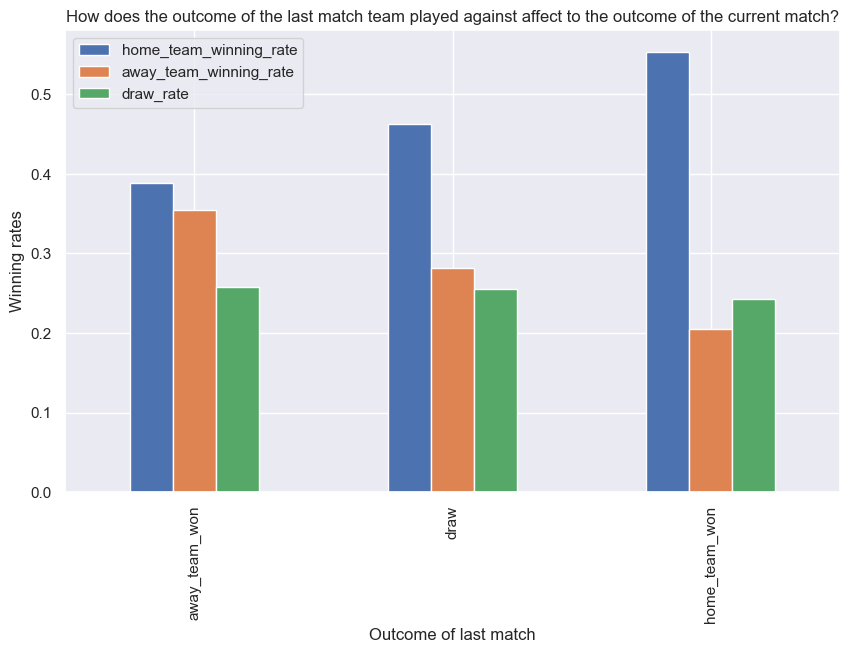

<IPython.core.display.Javascript object>

In [95]:
ax = last_result[
    ["home_team_winning_rate", "away_team_winning_rate", "draw_rate"]
].plot.bar(
    title="How does the outcome of the last match team played against affect to the outcome of the current match?"
)
ax.set_ylabel("Winning rates")
ax.set_xlabel("Outcome of last match")

Based on the analysis, the outcome of if the last match home team and away team played against each other does have an impact to the result of the current match. From the figure we can see that if a team won the last match, it increases the winning rate of that team. For example, if the home team of the current match won last time, the winning rate is about one third higher than if the last match was won by the current away team. Similar effect can be seen for the away team as well. Deeper analysis on the home advantage is presented in the section four.

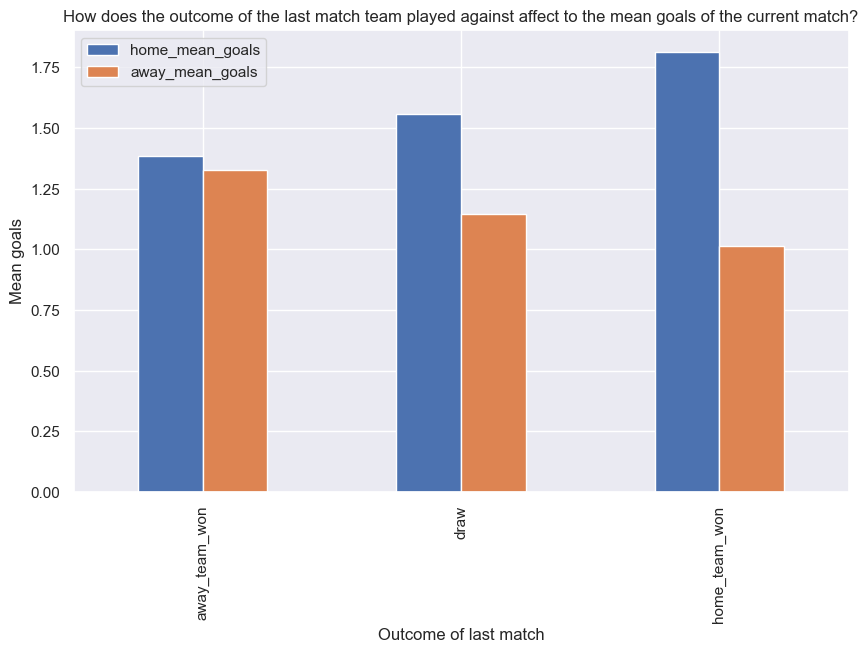

<IPython.core.display.Javascript object>

In [96]:
ax = last_result[["home_mean_goals", "away_mean_goals"]].plot.bar(
    title="How does the outcome of the last match team played against affect to the mean goals of the current match?"
)
ax.set_ylabel("Mean goals")
ax.set_xlabel("Outcome of last match")

Similarly the mean number of goals increases if the team won the last match. The impact level is quite the same as with the winning rates. Therefore we can conclude that the outcome of the last match does have an impact to the match outcome.

#### Goal difference of the last match

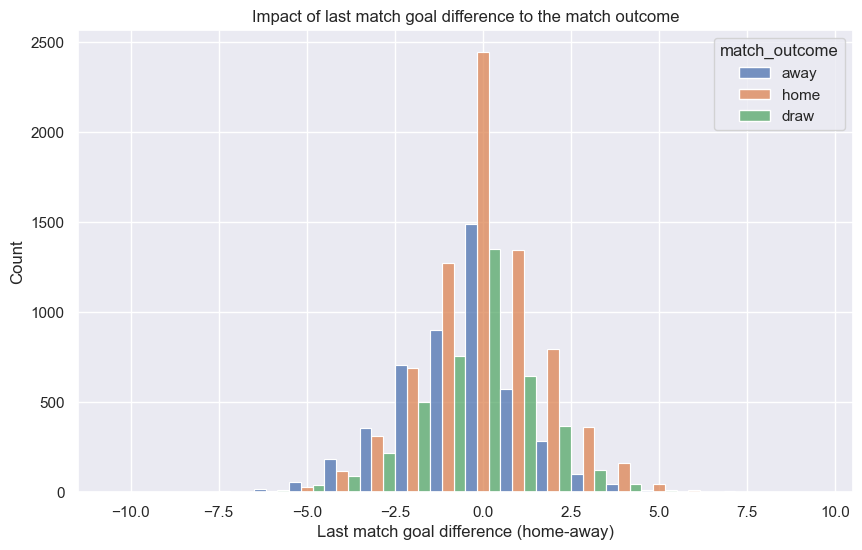

<IPython.core.display.Javascript object>

In [97]:
sns.histplot(
    matches_modelling_df,
    x="last_match_goal_difference",
    hue="match_outcome",
    multiple="dodge",
    discrete=True,
)
plt.title("Impact of last match goal difference to the match outcome")
plt.xlabel("Last match goal difference (home-away)")

The distribution shows that if the home team has won the last game with high goal difference, the home team has won more often. This basically supports the findings with the last-match-outcome feature. In addition, higher goal difference seems to increase the tendency of winning even more.

#### Points from the last five games

In [98]:
home_points = matches_modelling_df.groupby("home_points_history").agg(
    count=("league_id", "count"),
    wins=("home_win", "sum"),
    lose=("away_win", "sum"),
    draw=("draw", "sum"),
    mean_goals=("home_team_goal", "mean"),
    mean_goals_against=("away_team_goal", "mean"),
)
away_points = matches_modelling_df.groupby("away_points_history").agg(
    count=("league_id", "count"),
    wins=("away_win", "sum"),
    lose=("home_win", "sum"),
    draw=("draw", "sum"),
    mean_goals=("away_team_goal", "mean"),
    mean_goals_against=("home_team_goal", "mean"),
)
points = home_points.add(away_points, fill_value=0)
points["mean_goals"] = points["mean_goals"] / 2
points["mean_goals_against"] = points["mean_goals_against"] / 2
points["winning_rate"] = points["wins"] / points["count"]
points["losing_rate"] = points["lose"] / points["count"]
points["draw_rate"] = points["draw"] / points["count"]
points.index.name = "points_history"
points.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [99]:
points

points_history  count  wins  lose  draw  mean_goals  mean_goals_against  \
0              0.0    101    20    50    31    0.892680            1.565136   
1              1.0     85    26    31    28    1.122727            1.563636   
2              2.0    374    88   197    89    1.029251            1.609514   
3              3.0   1441   435   654   352    1.143116            1.538501   
4              4.0   1807   566   807   434    1.164713            1.516054   
5              5.0   2590   819  1122   649    1.196375            1.460472   
6              6.0   4597  1454  1915  1228    1.235937            1.468565   
7              7.0   3515  1134  1428   953    1.240150            1.473014   
8              8.0   4354  1526  1667  1161    1.332154            1.390115   
9              9.0   4687  1812  1703  1172    1.334746            1.358311   
10            10.0   1766   672   638   456    1.524587            1.365500   
11            11.0   4188  1860  1335   993    1.567237            1.254671   
12            12.0    350   176    99    75    1.906720            1.161369   
13            13.0   2390  1268   553   569    1.783688            1.043337   
14            15.0    785   489   146   150    2.075051            0.976748   

    winning_rate  losing_rate  draw_rate  
0       0.198020     0.495050   0.306931  
1       0.305882     0.364706   0.329412  
2       0.235294     0.526738   0.237968  
3       0.301874     0.453851   0.244275  
4       0.313226     0.446597   0.240177  
5       0.316216     0.433205   0.250579  
6       0.316293     0.416576   0.267131  
7       0.322617     0.406259   0.271124  
8       0.350482     0.382866   0.266651  
9       0.386601     0.363345   0.250053  
10      0.380521     0.361268   0.258211  
11      0.444126     0.318768   0.237106  
12      0.502857     0.282857   0.214286  
13      0.530544     0.231381   0.238075  
14      0.622930     0.185987   0.191083

<IPython.core.display.Javascript object>

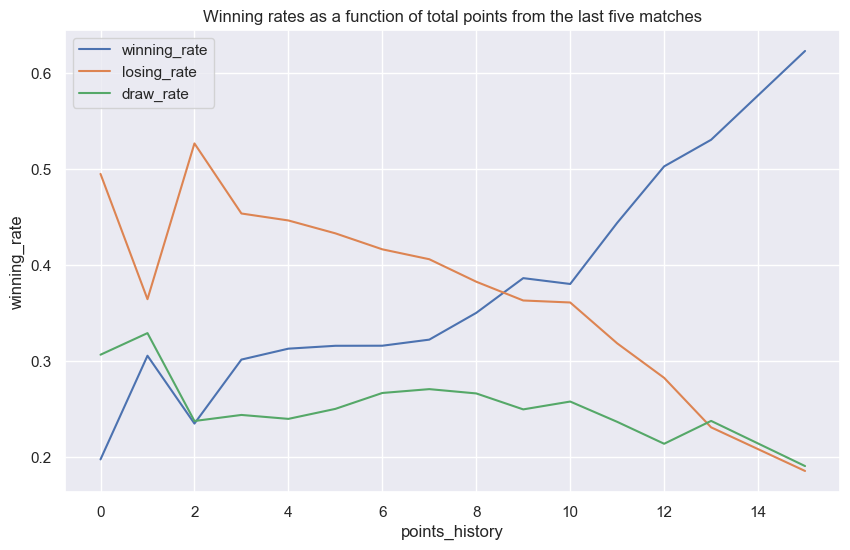

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots()
for col in ["winning_rate", "losing_rate", "draw_rate"]:
    sns.lineplot(data=points, x="points_history", y=col, label=col, ax=ax)
ax.set_title("Winning rates as a function of total points from the last five matches")

It is clearly seen that the winning rate correlates strongly with the points won from the last five games. Similarly, the losing rate has a negative correlation. This can be seen also from the correlation matrix below.

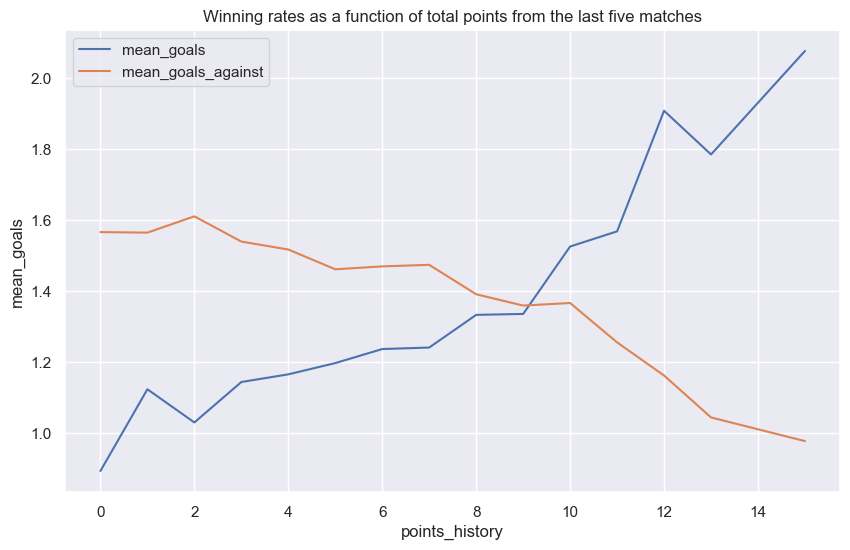

<IPython.core.display.Javascript object>

In [101]:
fig, ax = plt.subplots()
for col in ["mean_goals", "mean_goals_against"]:
    sns.lineplot(data=points, x="points_history", y=col, label=col, ax=ax)
ax.set_title("Winning rates as a function of total points from the last five matches")

Similar findings can be found from here. 

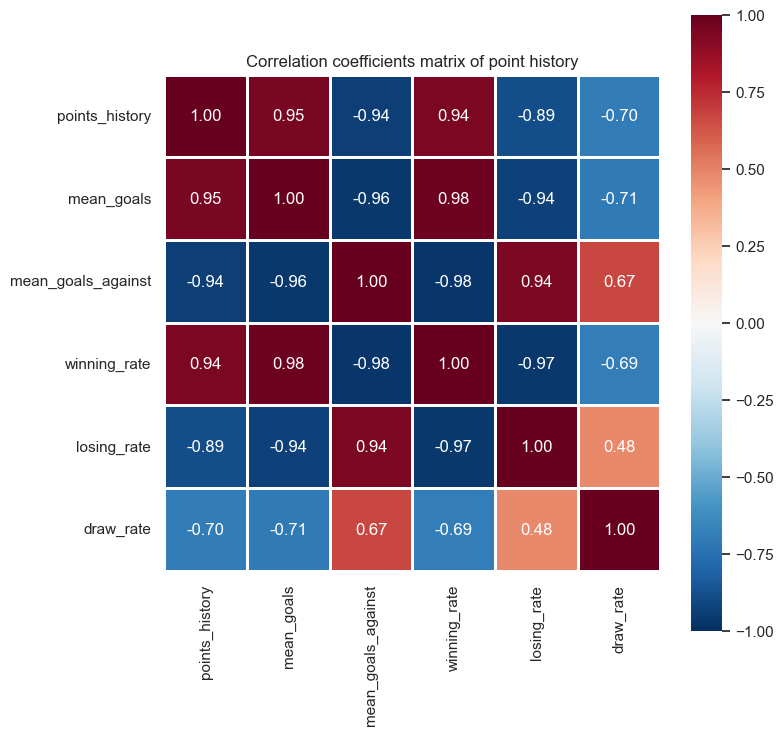

<IPython.core.display.Javascript object>

In [102]:
plt.figure(figsize=(8, 8))
plt.title(
    "Correlation coefficients matrix of point history",
)
ax = sns.heatmap(
    points[
        [
            "points_history",
            "mean_goals",
            "mean_goals_against",
            "winning_rate",
            "losing_rate",
            "draw_rate",
        ]
    ].corr(),
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)

When the correlations are investigated between the points history and winning rate or mean number of goals. It is clearly seen that there is correlation between the team's previous performance and winning rate or average number of goals.

#### Mean goals from the last ten games

Next, the impact of the mean goals from the last ten games on the current match outcome is investigated. The average is taken from longer period than the point history to avoid the correlation between the historical features. This way there is a short and a long term historical feature that measures the performance of the team.

In [103]:
home_means = matches_modelling_df.groupby("match_outcome")["home_goals_history"].mean()
home_means

match_outcome
away    1.229804
draw    1.299540
home    1.484013
Name: home_goals_history, dtype: float64

<IPython.core.display.Javascript object>

In [104]:
away_means = matches_modelling_df.groupby("match_outcome")["away_goals_history"].mean()
away_means

match_outcome
away    1.550080
draw    1.384506
home    1.290856
Name: away_goals_history, dtype: float64

<IPython.core.display.Javascript object>

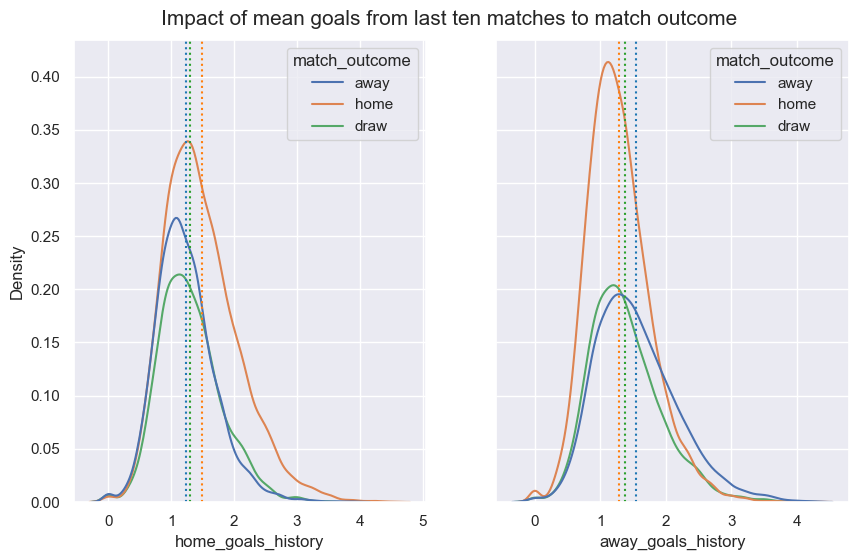

<IPython.core.display.Javascript object>

In [105]:
indxs = ["away", "home", "draw"]

fig, axs = plt.subplots(1, 2, sharey=True)

sns.kdeplot(
    matches_modelling_df,
    x="home_goals_history",
    hue="match_outcome",
    ax=axs[0],
    alpha=1,
)
sns.kdeplot(
    matches_modelling_df,
    x="away_goals_history",
    hue="match_outcome",
    ax=axs[1],
    alpha=1,
)
for color, ind in zip(sns.color_palette("tab10", 3), indxs):
    axs[0].axvline(x=home_means.loc[ind], color=color, linestyle=":")
    axs[1].axvline(x=away_means.loc[ind], color=color, linestyle=":")

plt.suptitle(
    "Impact of mean goals from last ten matches to match outcome", fontsize=15, y=0.93
)

Here are the distributions and mean values (vertical lines) of the mean goals from previous ten games presented for each match outcome. 

As can be seen there is some variation that supports the idea that teams that make more goals in average tend to win. The winner team tend to have slightly higher average goals from previous matches. For home team than wins, the mean value for mean goals from previous ten games is slightly higher than for home team that loses. For the away teams similar pattern is seen.

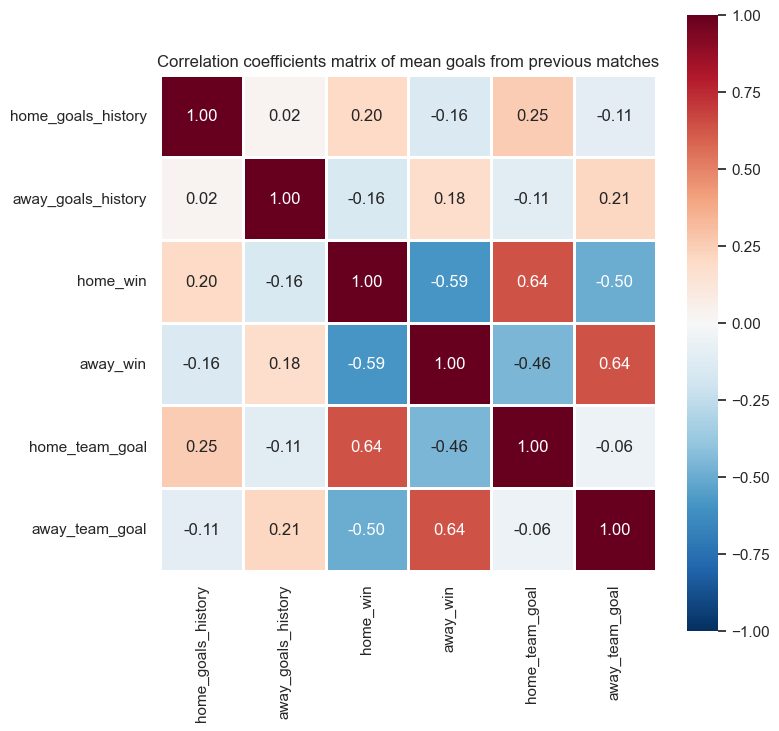

<IPython.core.display.Javascript object>

In [106]:
plt.figure(figsize=(8, 8))
plt.title(
    "Correlation coefficients matrix of mean goals from previous matches",
)
ax = sns.heatmap(
    matches_modelling_df[
        [
            "home_goals_history",
            "away_goals_history",
            "home_win",
            "away_win",
            "home_team_goal",
            "away_team_goal",
        ]
    ].corr(),
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)

As the historical mean of goals is from a longer period than the point history feature, the impact to the match outcome or number of goals teams will make is not as significant which is seen as small correlation coefficients.

***

## 4. Statistical analysis on home advantage

### 4.1 Winning rates at home

Next the home advantage is investigated. Does the home team win more often than the away team? This is tested by comparing  mean winning rates between home and away for each team.

**Paired two-sample t-test**
- Target population: European football league matches
- Significance level: $\alpha = 0.05$
- Null hypothesis: There is no difference in the mean values of winning rates or the home winning rate is smaller than away wining rate.
- Alternative hypothesis: The mean winning rate of home wins is larger.

**Assumptions**
- Obervations are independent.
- Difference between winning rates is normally distributed. See graph below.

In [107]:
winning_rate_df = pd.read_sql_query(
    """
    WITH home AS (
    SELECT th.team_long_name AS team_name, AVG(m.home_win) AS home_win, 
        AVG(m.away_win) AS home_lose, AVG(m.draw) AS home_draw
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.home_team_api_id = th.team_api_id
    GROUP BY 1)
    
    SELECT 
        th.team_long_name AS team_name,
        h.home_win, 
        h.home_lose, 
        h.home_draw, 
        AVG(m.home_win) AS away_lose, 
        AVG(m.away_win) AS away_win, 
        AVG(m.draw) AS away_draw,
        (AVG(m.away_win) + h.home_win)*0.5 AS total_winning_rate, 
        (AVG(m.home_win) + h.home_lose)*0.5 AS total_losing_rate, 
        (AVG(m.draw) + h.home_draw)*0.5 AS total_draw
    FROM Match_temp m
    INNER JOIN Team_temp th
    ON m.away_team_api_id = th.team_api_id
    INNER JOIN home h
    ON h.team_name = th.team_long_name
    GROUP BY 1 """,
    conn,
)

<IPython.core.display.Javascript object>

In [108]:
winning_rate_df.sort_values(by="home_win", ascending=False)

team_name  home_win  home_lose  home_draw  away_lose  \
74            FC Barcelona  0.861842   0.059211   0.078947   0.118421   
208         Real Madrid CF  0.848684   0.078947   0.072368   0.184211   
229             SL Benfica  0.837607   0.059829   0.102564   0.152542   
88                FC Porto  0.823529   0.050420   0.126050   0.136752   
76        FC Bayern Munich  0.801471   0.095588   0.102941   0.161765   
..                     ...       ...        ...        ...        ...   
56   DSC Arminia Bielefeld  0.117647   0.411765   0.470588   0.411765   
5         AC Arles-Avignon  0.105263   0.578947   0.315789   0.684211   
61    Dunfermline Athletic  0.052632   0.578947   0.368421   0.631579   
55              Córdoba CF  0.052632   0.631579   0.315789   0.631579   
241   SpVgg Greuther Fürth  0.000000   0.764706   0.235294   0.470588   

     away_win  away_draw  total_winning_rate  total_losing_rate  total_draw  
74   0.677632   0.203947            0.769737           0.088816    0.141447  
208  0.651316   0.164474            0.750000           0.131579    0.118421  
229  0.686441   0.161017            0.762024           0.106186    0.131791  
88   0.658120   0.205128            0.740825           0.093586    0.165589  
76   0.617647   0.220588            0.709559           0.128676    0.161765  
..        ...        ...                 ...                ...         ...  
56   0.117647   0.470588            0.117647           0.411765    0.470588  
5    0.052632   0.263158            0.078947           0.631579    0.289474  
61   0.210526   0.157895            0.131579           0.605263    0.263158  
55   0.105263   0.263158            0.078947           0.631579    0.289474  
241  0.235294   0.294118            0.117647           0.617647    0.264706  

[293 rows x 10 columns]

<IPython.core.display.Javascript object>

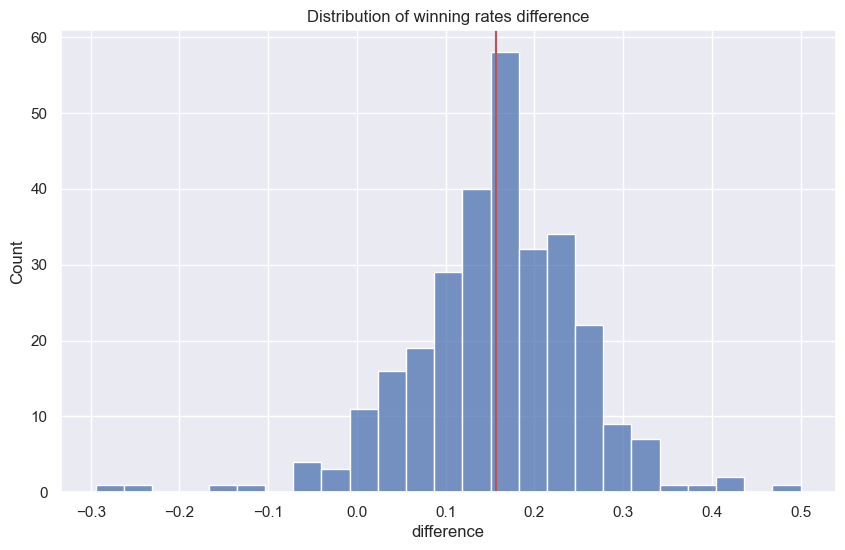

<IPython.core.display.Javascript object>

In [109]:
winning_rate_df["difference"] = (
    winning_rate_df["home_win"] - winning_rate_df["away_win"]
)
ax = sns.histplot(winning_rate_df["difference"])
ax.axvline(x=np.mean(winning_rate_df["difference"]), c="r")
ax.set_title("Distribution of winning rates difference")

Difference of means is roughly normally distributed so the assumption holds. 

Next, the test is conducted.

In [110]:
t_value, pvalue = ttest_rel(winning_rate_df["home_win"], winning_rate_df["away_win"])
print(f"T-test results: t-value {t_value:.5f}, p-value {pvalue/2:.5e}")

T-test results: t-value 27.80065, p-value 2.49526e-84


<IPython.core.display.Javascript object>

The results show that the null hypothesis can be rejected. The mean home winning rate is not equal or smaller than the away wining rate. The difference is statistically significant. Teams win in home games more often. Difference is quite large and can be confirmed with the confidence of 95%.

In [111]:
print(f"Mean home winning rate: {winning_rate_df['home_win'].mean():.3f}")
print(f"Mean away winning rate: {winning_rate_df['away_win'].mean():.3f}")
print(
    f"Difference of mean winning rates: {winning_rate_df['home_win'].mean() - winning_rate_df['away_win'].mean():.3f}"
)

Mean home winning rate: 0.404
Mean away winning rate: 0.247
Difference of mean winning rates: 0.157


<IPython.core.display.Javascript object>

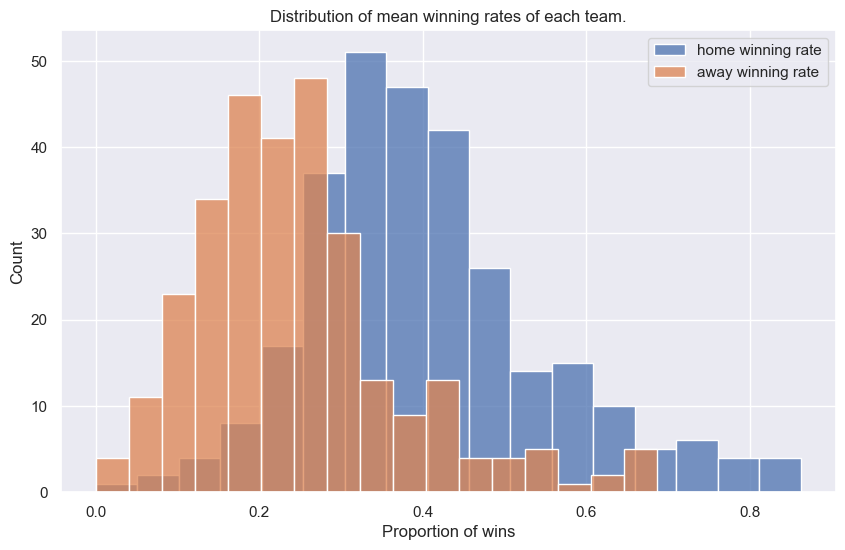

<IPython.core.display.Javascript object>

In [112]:
ax = sns.histplot(x=winning_rate_df["home_win"], label="home winning rate")
sns.histplot(x=winning_rate_df["away_win"], label="away winning rate", ax=ax)
ax.legend().set_visible(True)
ax.set_title("Distribution of mean winning rates of each team.")
ax.set_xlabel("Proportion of wins")

The difference in clearly seen from the distributions as well.

Next the average winning rates are calculated for each season of each league.

In [113]:
match_dfg = pd.read_sql_query(
    """
    SELECT 
        l.name league, 
        tb.season, 
        tb.match_outcome, 
        tb.number_of_wins AS wins, 
        CAST(SUM(tb.number_of_wins) OVER(PARTITION BY l.name, tb.season) AS DOUBLE) AS total_matches_in_season,
        tb.number_of_wins / SUM(tb.number_of_wins) OVER(PARTITION BY l.name, tb.season) proportion_of_wins
    FROM (SELECT league_id, season, match_outcome, CAST(COUNT(*) AS DOUBLE) AS number_of_wins
            FROM Match_temp
            GROUP BY 1,2,3) tb
    INNER JOIN League l
    ON tb.league_id = l.id
    """,
    conn,
)

<IPython.core.display.Javascript object>

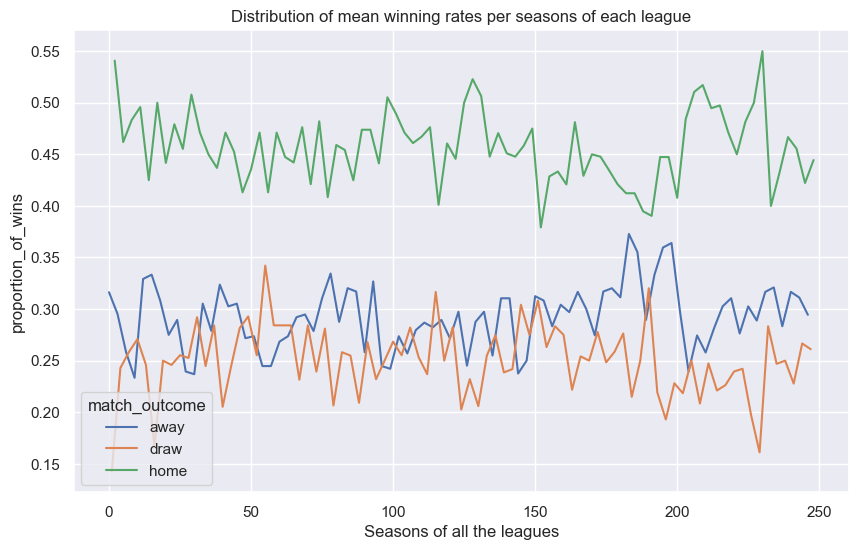

<IPython.core.display.Javascript object>

In [114]:
ax = sns.lineplot(
    x=match_dfg.index,
    y=match_dfg["proportion_of_wins"],
    hue=match_dfg["match_outcome"],
)
ax.set_title("Distribution of mean winning rates per seasons of each league")
ax.set_xlabel("Seasons of all the leagues")

The data shows that winnig rate at home is clearly higher than the rest.

### 4.2 Amount of goals at home

Next, the home advantage is investigated in term of goals. Do teams make more goals at home in average. This is tested by comparing  mean number of goals between home and away matches of each team.


**Paired two-sample t-test**
- Target population: European football league matches
- Significance level: $\alpha = 0.05$
- Null hypothesis: There is no difference in the mean number of goals at between home and away matches or the mean of home matches is smaller.
- Alternative hypothesis: The mean number of goals at home games is larger.

**Assumptions**
- Obervations are independent.
- Difference between winning rates is normally distributed. See graph below.

In [115]:
home_goals_df = match_temp_df.groupby("home_team_api_id").agg(
    {"home_team_goal": "mean"}
)
away_goals_df = match_temp_df.groupby("away_team_api_id").agg(
    {"away_team_goal": "mean"}
)
total_goals_df = home_goals_df.merge(
    away_goals_df,
    how="inner",
    left_index=True,
    right_index=True,
)
total_goals_df.index.rename(name="team_id", inplace=True)

<IPython.core.display.Javascript object>

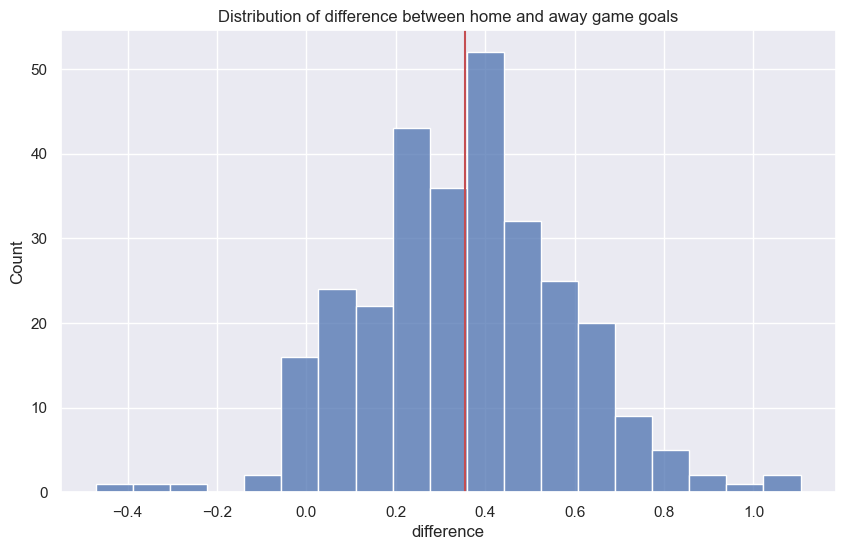

<IPython.core.display.Javascript object>

In [116]:
total_goals_df["difference"] = (
    total_goals_df["home_team_goal"] - total_goals_df["away_team_goal"]
)
ax = sns.histplot(total_goals_df["difference"])
ax.axvline(x=np.mean(total_goals_df["difference"]), c="r")
ax.set_title("Distribution of difference between home and away game goals")

Difference of means is roughly normally distributed so the assumption holds. 

Next, the test is conducted.

In [117]:
t_value, pvalue = ttest_rel(
    total_goals_df["home_team_goal"], total_goals_df["away_team_goal"]
)
print(f"T-test results: t-value {t_value:.5f}, p-value {pvalue/2:.5e}")

T-test results: t-value 26.64849, p-value 1.37407e-80


<IPython.core.display.Javascript object>

The results show that the null hypothesis can be rejected. The mean number of goals in home games is not equal or smaller than the mean nubmer of goals in away games. Teams make more goals at home in average in home games more often.

In [118]:
print(f"Mean number of goals at home: {total_goals_df['home_team_goal'].mean():.3f}")
print(f"Mean number of goals away: {total_goals_df['away_team_goal'].mean():.3f}")
print(
    f"Difference of means: {total_goals_df['home_team_goal'].mean() - total_goals_df['away_team_goal'].mean():.3f}"
)

Mean number of goals at home: 1.420
Mean number of goals away: 1.064
Difference of means: 0.355


<IPython.core.display.Javascript object>

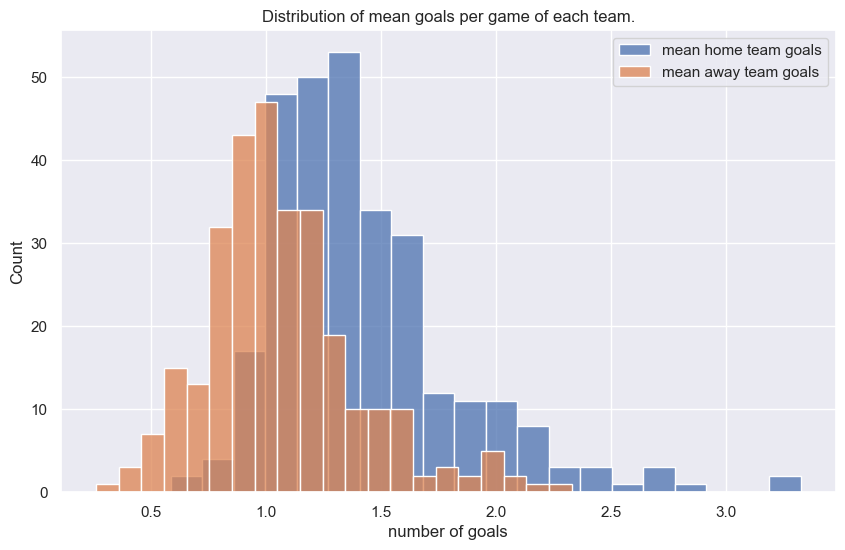

<IPython.core.display.Javascript object>

In [119]:
ax = sns.histplot(x=total_goals_df["home_team_goal"], label="mean home team goals")
sns.histplot(x=total_goals_df["away_team_goal"], label="mean away team goals", ax=ax)
ax.legend().set_visible(True)
ax.set_title("Distribution of mean goals per game of each team.")
ax.set_xlabel("number of goals")

The difference in clearly seen from the distributions as well.

We can conclude that home advantage is important factor in football matches and it will be considered also in the model building.

In [120]:
cur.close()

<IPython.core.display.Javascript object>

## 5. Modelling

Finally, based on the data analysis the model for predicting match outcome and goals will be presented in this section.

First, a multinomial logistic regression model is built to predict the match outcome. The a multinomial model is selected because the problem in hand has multiple classess, and the model's regression coefficients and p-values can be used to estimate the relationships between the predictors and target variable.

Secondly, a Poisson regression model is built to predict match scores. The model is selected because the match goals seem to follow Poisson distribution and can be presented as counts, and the model's coefficeints and p-values can be used to estimate the relationships between predictors and target variables.

About the initial feature selection for the model builing. The betting odds from other betting companies are not used in the modelling as the aim is to create a new model that predicts the result of the games based on match history, team and player attributes and such information that is available pre-game. Therefore, in-game data is not included into the data either.

The overall score of the player is used only from the player attributes to avoid multicollinearity and numerical instability of the models. This way the model will not be to complex and the number of features feasible. From the team attributes only the numerical features are included to later analysis as the categorical features are duplicates from the numerical features.

In addition, the history featues and playing formations are used in the model.

### 5.1 Predicting match outcome


The target feature for the model is the match outcome feature, which have values 'home' indicating win of the home team, 'away' indicating the win of the away team and 'draw' indicating a tie. The used model is multinomial logistic refression.

The data is split into training and testing sets. The predictors are standardized. Then backward elimnation is used as a feature selection tehchnique to identify the most significant predictors for the model. Starting with a model including all the features, the features are iteratively removed based on their p-values. 

The most optimal threshold for p-value is selected by comparing five different values. Cross validation is used to evaluate the performance of models during the process. The model with highest F1-score is selected. After that the selected model's performance is evaluated with the test data.

- Target population: European football league matches
- Significance levels: $\alpha = [0.05, 0.1875, 0.325 , 0.4625, 0.6]$

Assumptions for multinomial logistic regression are met.
- Observations are independent from each other.
- Enough large sample size.
- No multicollinearity among the independent variables.


In [121]:
outcome_model_df = matches_modelling_df.copy()
outcome_model_df = duckdb.query(
    """
SELECT m.* EXCLUDE (
            match_api_id, 
            home_team_api_id, 
            away_team_api_id, 
            home_team_goal, 
            away_team_goal,
            league_id,
            stage,
            date,
            season, 
            home_win, 
            away_win, 
            draw)
FROM outcome_model_df m
"""
).df()

<IPython.core.display.Javascript object>

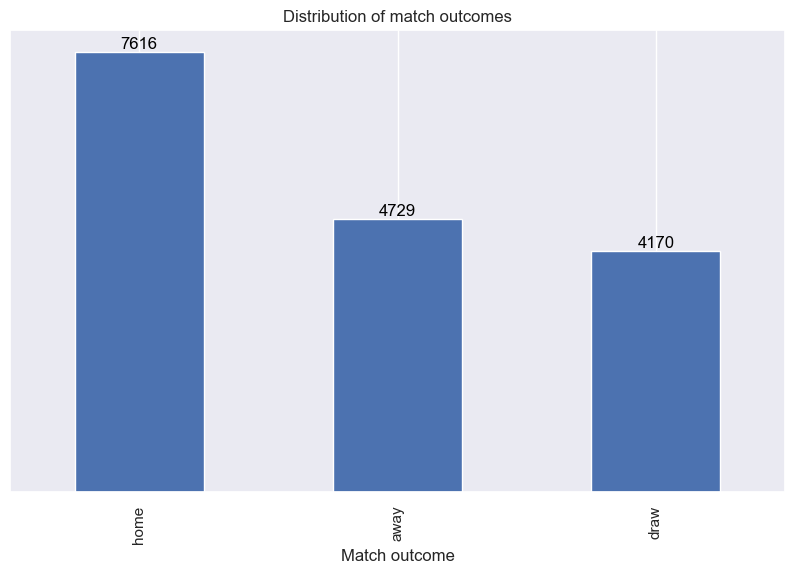

<IPython.core.display.Javascript object>

In [122]:
ax = outcome_model_df.match_outcome.value_counts().plot.bar(
    title="Distribution of match outcomes"
)
ax.set_yticks([])
ax.set_xlabel("Match outcome")
for container in ax.containers:
    ax.bar_label(container, padding=0, color="black")

Dataset for modelling is slightly unbalanced. Let's try to take this into account when dividing data to training and test sets. In addition, cross-validation is used to assess this issue.

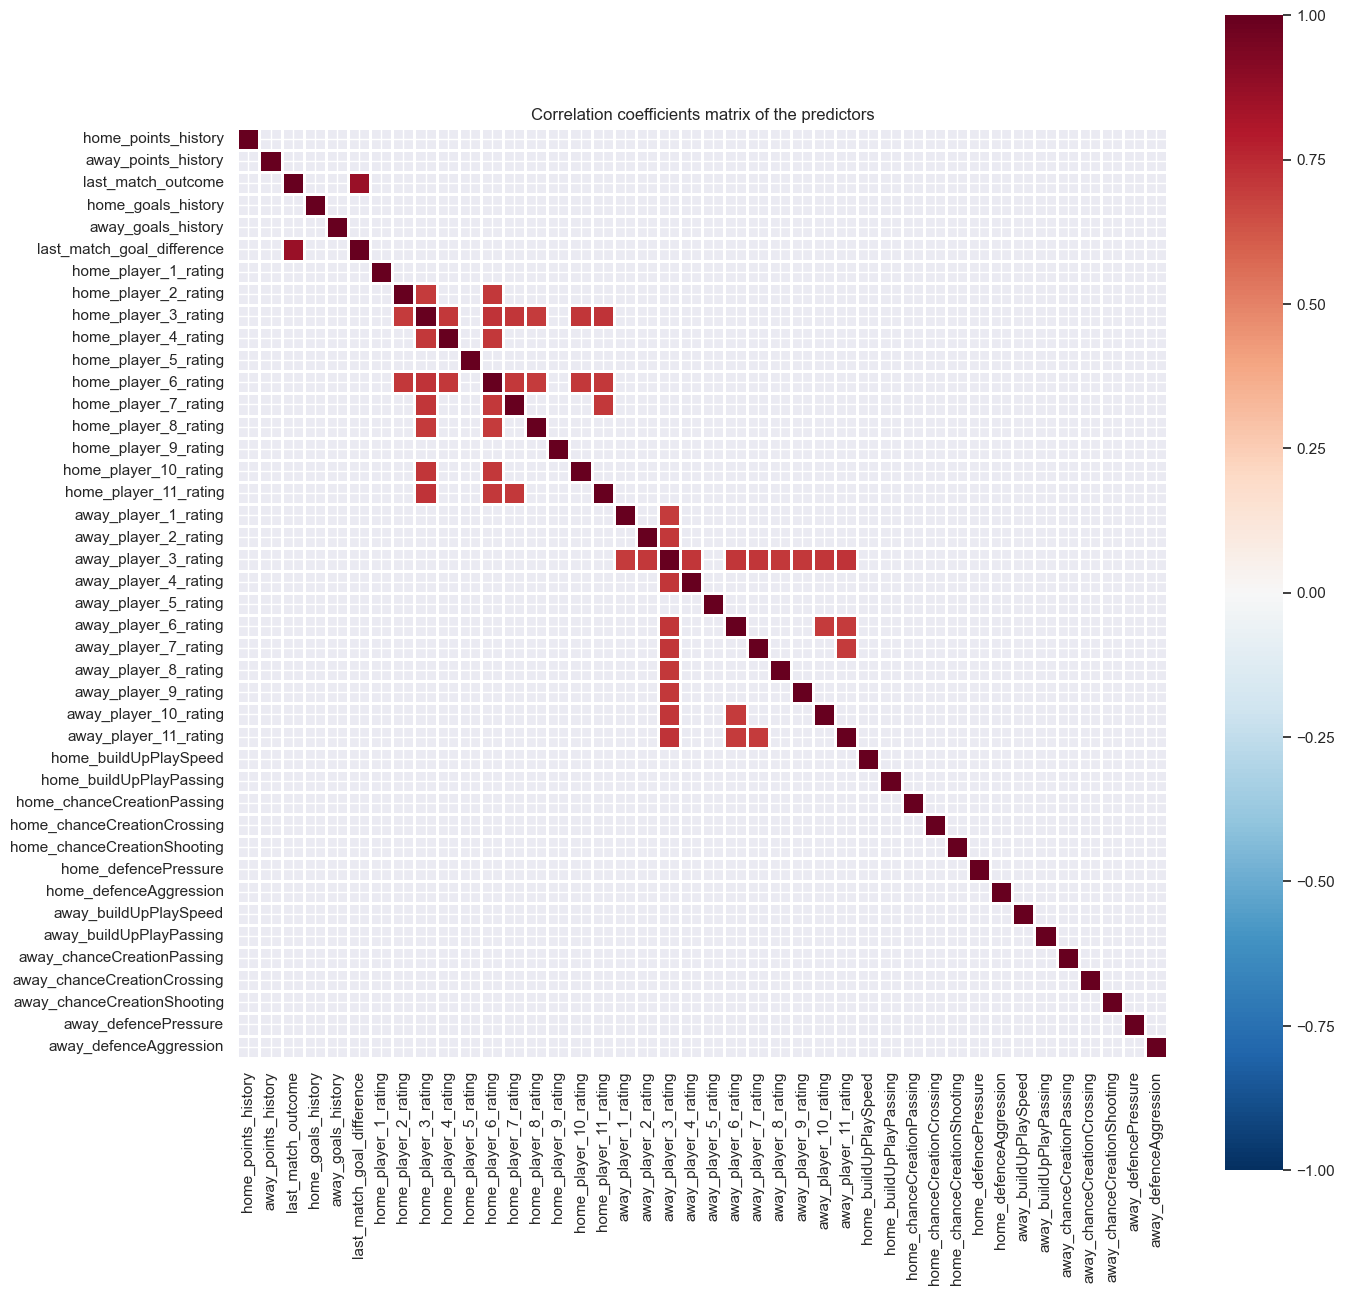

<IPython.core.display.Javascript object>

In [123]:
numeric_cols = outcome_model_df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 15))
plt.title(
    "Correlation coefficients matrix of the predictors",
)
ax = sns.heatmap(
    outcome_model_df[numeric_cols].corr()[
        (outcome_model_df[numeric_cols].corr() < -0.7)
        | (outcome_model_df[numeric_cols].corr() > 0.7)
    ],
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cmap="RdBu_r",
    annot=False,
    fmt=".2f",
)

There is high correlation between player ratings so they are combined to summary statistics for each team to avoid problems due to multicollinearity. A mean, and standard deviation of the player ratings are calculated for both teams.

In [124]:
outcome_model_df = preprocessingtools.calculate_team_ratings_summary(outcome_model_df)

<IPython.core.display.Javascript object>

Reduce the number of features by reducing formation types to 4. The three most popular formations consist of 74% of the team. Rest formations are combined into 'others' category. Then the home and away formations are combined to home formation vs away formation feature to improve numerical stability of the model.

In [125]:
popular_formation = ["442", "4231", "433"]
outcome_model_df.loc[
    ~outcome_model_df["home_formation"].isin(popular_formation), "home_formation"
] = "other"
outcome_model_df.loc[
    ~outcome_model_df["away_formation"].isin(popular_formation), "away_formation"
] = "other"

<IPython.core.display.Javascript object>

In [126]:
outcome_model_df["formations"] = (
    outcome_model_df["home_formation"] + " vs " + outcome_model_df["away_formation"]
)
outcome_model_df.drop(columns=["home_formation", "away_formation"], inplace=True)

<IPython.core.display.Javascript object>

In [127]:
outcome_model_df.formations.value_counts()

other vs other    2389
4231 vs 4231      2219
442 vs 442        2156
433 vs 433        1397
4231 vs other     1216
other vs 4231     1165
442 vs other      1000
other vs 442       816
4231 vs 433        587
433 vs 4231        579
433 vs other       573
other vs 433       557
442 vs 4231        538
4231 vs 442        481
442 vs 433         429
433 vs 442         413
Name: formations, dtype: int64

<IPython.core.display.Javascript object>

In [128]:
y = outcome_model_df["match_outcome"]
X = outcome_model_df.loc[:, outcome_model_df.columns != "match_outcome"]

<IPython.core.display.Javascript object>

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [130]:
scaler = StandardScaler().fit(
    X_train.loc[
        :,
        X_train.columns[~X_train.columns.isin(["formations"])],
    ]
)
X_train.loc[
    :,
    X_train.columns[~X_train.columns.isin(["formations"])],
] = scaler.transform(
    X_train.loc[
        :,
        X_train.columns[~X_train.columns.isin(["formations"])],
    ]
)
X_test.loc[:, X_test.columns[~X_test.columns.isin(["formations"])],] = scaler.transform(
    X_test.loc[
        :,
        X_test.columns[~X_test.columns.isin(["formations"])],
    ]
)

<IPython.core.display.Javascript object>

In [131]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

<IPython.core.display.Javascript object>

In [132]:
X_train.describe()

home_points_history  away_points_history  last_match_outcome  \
count         1.238600e+04         1.238600e+04        1.238600e+04   
mean         -2.570024e-16         1.973411e-16       -1.147332e-17   
std           1.000040e+00         1.000040e+00        1.000040e+00   
min          -2.777954e+00        -2.679911e+00       -1.113868e+00   
25%          -6.952032e-01        -6.815538e-01       -1.113868e+00   
50%          -9.528706e-04        -1.543486e-02        1.036019e-01   
75%           6.932974e-01         6.506841e-01        1.321072e+00   
max           2.428923e+00         2.315981e+00        1.321072e+00   

       home_goals_history  away_goals_history  last_match_goal_difference  \
count        1.238600e+04        1.238600e+04                1.238600e+04   
mean        -1.330905e-16        3.877982e-16               -1.720998e-17   
std          1.000040e+00        1.000040e+00                1.000040e+00   
min         -2.480293e+00       -2.510388e+00               -5.612440e+00   
25%         -6.619355e-01       -6.989457e-01               -4.534491e-01   
50%         -1.164282e-01       -1.555130e-01                1.197720e-01   
75%          6.109148e-01        5.690639e-01                6.929932e-01   
max          5.702316e+00        5.278814e+00                4.132320e+00   

       home_buildUpPlaySpeed  home_buildUpPlayPassing  \
count           1.238600e+04             1.238600e+04   
mean            1.835731e-17            -1.302222e-16   
std             1.000040e+00             1.000040e+00   
min            -2.890856e+00            -2.532885e+00   
25%            -6.180274e-01            -8.206832e-01   
50%            -6.111956e-03             8.047569e-02   
75%             7.806365e-01             6.211710e-01   
max             2.179300e+00             2.874068e+00   

       home_chanceCreationPassing  home_chanceCreationCrossing  ...  \
count                1.238600e+04                 1.238600e+04  ...   
mean                 1.984884e-16                -2.894145e-16  ...   
std                  1.000040e+00                 1.000040e+00  ...   
min                 -2.978852e+00                -3.079259e+00  ...   
25%                 -5.252109e-01                -5.684693e-01  ...   
50%                 -5.335691e-02                -3.044298e-02  ...   
75%                  7.016095e-01                 8.662675e-01  ...   
max                  2.589026e+00                 2.301004e+00  ...   

       formations_433 vs 442  formations_433 vs other  formations_442 vs 4231  \
count           12386.000000             12386.000000            12386.000000   
mean                0.024705                 0.035443                0.031245   
std                 0.155232                 0.184905                0.173986   
min                 0.000000                 0.000000                0.000000   
25%                 0.000000                 0.000000                0.000000   
50%                 0.000000                 0.000000                0.000000   
75%                 0.000000                 0.000000                0.000000   
max                 1.000000                 1.000000                1.000000   

       formations_442 vs 433  formations_442 vs 442  formations_442 vs other  \
count           12386.000000           12386.000000             12386.000000   
mean                0.025270               0.131681                 0.063136   
std                 0.156952               0.338157                 0.243217   
min                 0.000000               0.000000                 0.000000   
25%                 0.000000               0.000000                 0.000000   
50%                 0.000000               0.000000                 0.000000   
75%                 0.000000               0.000000                 0.000000   
max                 1.000000               1.000000                 1.000000   

       formations_other vs 4231  formations_other vs 433  \
count   

<IPython.core.display.Javascript object>

Training and backward elimination of features with comparison of different p-values.

In [133]:
alphas = np.linspace(0.05, 0.6, 5)
model_fit = featureselection.model_selection_MNLogit(X_train, y_train, alphas, 5)

****************************************************************************************************
Fold 0
Optimization terminated successfully.
         Current function value: 0.976463
         Iterations 5
Initial Model Summary:
Confusion Matrix : 
 [[[1372  397]
  [ 373  336]]

 [[1836   16]
  [ 621    5]]

 [[ 552  783]
  [ 202  941]]]
Accuracy score:  0.5173527037933817
              precision    recall  f1-score   support

        away       0.46      0.47      0.47       709
        draw       0.24      0.01      0.02       626
        home       0.55      0.82      0.66      1143

    accuracy                           0.52      2478
   macro avg       0.41      0.44      0.38      2478
weighted avg       0.44      0.52      0.44      2478

Performing backward elimination.

feature_index: 8
Optimization terminated successfully.
         Current function value: 0.976507
         Iterations 5
Feature home_chanceCreationPassing dropped.
Pvalue: 0.9859378686823556.
feature_index:

feature_index: 34
Optimization terminated successfully.
         Current function value: 0.978945
         Iterations 5
Feature formations_other vs 4231 dropped.
Pvalue: 0.931787959919578.
feature_index: 12
Optimization terminated successfully.
         Current function value: 0.978973
         Iterations 5
Feature away_buildUpPlayPassing dropped.
Pvalue: 0.9279755763049178.
feature_index: 16
Optimization terminated successfully.
         Current function value: 0.979207
         Iterations 5
Feature away_defenceAggression dropped.
Pvalue: 0.8985912712175738.
feature_index: 15
Optimization terminated successfully.
         Current function value: 0.979390
         Iterations 5
Feature away_defencePressure dropped.
Pvalue: 0.8935391158129842.
feature_index: 6
Optimization terminated successfully.
         Current function value: 0.979429
         Iterations 5
Feature home_buildUpPlayPassing dropped.
Pvalue: 0.8138878439313785.
feature_index: 7
Optimization terminated successfully.
     

Optimization terminated successfully.
         Current function value: 0.991781
         Iterations 5
Feature home_defenceAggression dropped.
Pvalue: 0.9293044747848392.
feature_index: 25
Optimization terminated successfully.
         Current function value: 0.994437
         Iterations 5
Feature formations_442 vs other dropped.
Pvalue: 0.7979923213268426.
feature_index: 23
Optimization terminated successfully.
         Current function value: 0.995176
         Iterations 5
Feature formations_442 vs 4231 dropped.
Pvalue: 0.7952496799511651.
feature_index: 6
Optimization terminated successfully.
         Current function value: 0.995186
         Iterations 5
Feature home_buildUpPlayPassing dropped.
Pvalue: 0.7249625218942933.
feature_index: 20
Optimization terminated successfully.
         Current function value: 0.995938
         Iterations 5
Feature formations_433 vs 442 dropped.
Pvalue: 0.6917133473204093.
feature_index: 1
Optimization terminated successfully.
         Current functi

Feature away_buildUpPlaySpeed dropped.
Pvalue: 0.6911355604585081.
feature_index: 21
Optimization terminated successfully.
         Current function value: 0.989967
         Iterations 5
Feature formations_other vs 4231 dropped.
Pvalue: 0.6454290326561423.
feature_index: 12
Optimization terminated successfully.
         Current function value: 0.990040
         Iterations 5
Feature away_std_rating dropped.
Pvalue: 0.7089852827198129.
feature_index: 1
Optimization terminated successfully.
         Current function value: 0.990746
         Iterations 5
Feature home_goals_history dropped.
Pvalue: 0.6441769810074356.
feature_index: 3
Optimization terminated successfully.
         Current function value: 0.990962
         Iterations 5
Feature home_buildUpPlayPassing dropped.
Pvalue: 0.6069458845662368.
feature_index: 4
Optimization terminated successfully.
         Current function value: 0.991023
         Iterations 5
Feature home_chanceCreationCrossing dropped.
Pvalue: 0.7008207087955538.

<IPython.core.display.Javascript object>

Selected model

In [134]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:          match_outcome   No. Observations:                 9909
Model:                        MNLogit   Df Residuals:                     9887
Method:                           MLE   Df Model:                           20
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.05414
Time:                        14:20:48   Log-Likelihood:                -9958.5
converged:                       True   LL-Null:                       -10529.
Covariance Type:            nonrobust   LLR p-value:                4.749e-229
==============================================================================================
        match_outcome=draw       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
home_points_history            0.0437      0.029      1.504      0.132      -0.013       0.101
away_goals_history            -0.0830      0.030     -2.790      0.005      -0.141      -0.025
last_match_goal_difference     0.0535      0.028      1.880      0.060      -0.002       0.109
home_avg_rating                0.4018      0.041      9.810      0.000       0.322       0.482
away_avg_rating               -0.3897      0.040     -9.639      0.000      -0.469      -0.310
away_std_rating               -0.0451      0.026     -1.707      0.088      -0.097       0.007
formations_4231 vs 433        -0.2312      0.144     -1.607      0.108      -0.513       0.051
formations_433 vs 4231        -0.2076      0.156     -1.333      0.183      -0.513       0.098
formations_433 vs other        0.3967      0.158      2.514      0.012       0.087       0.706
formations_other vs 433       -0.2875      0.153     -1.885      0.059      -0.586       0.011
formations_other vs other      0.2321      0.073      3.181      0.001       0.089       0.375
----------------------------------------------------------------------------------------------
        match_outcome=home       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
home_points_history            0.1508      0.029      5.166      0.000       0.094       0.208
away_goals_history            -0.1145      0.031     -3.725      0.000      -0.175      -0.054
last_match_goal_difference     0.0784      0.029      2.719      0.007       0.022       0.135
home_avg_rating                1.0319      0.042     24.797      0.000       0.950       1.114
away_avg_rating               -0.9936      0.042    -23.778      0.000      -1.075      -0.912
away_std_rating               -0.0377      0.026     -1.427      0.154      -0.090       0.014
formations_4231 vs 433         0.2816      0.135      2.090      0.037       0.018       0.546
formations_433 vs 4231         0.3449      0.141      2.442      0.015       0.068       0.622
formations_433 vs other        0.8196      0.150      5.454      0.000       0.525       1.114
formations_other vs 433        0.2452      0.141      1.737      0.082      -0.031       0.522
formations_other vs other      0.6602      0.070      9.446      0.000       0.523       0.797
==============================================================================================
"""

<IPython.core.display.Javascript object>

Based on the selected features, we can conclude that some of the findings from the EDA are confirmed with the model. The historical features and playing formations have impact to the match outcome. However, mean player overall rating seems to be important factor in the oucome predicting as they have the highest coefficients for home winning class. This was not seen in the exploratory analysis.

#### Performance of the model

In [135]:
X_test = X_test.loc[:, X_test.columns.isin(model_fit.params.index)]

<IPython.core.display.Javascript object>

In [136]:
y_hat = model_fit.predict(X_test)
prediction = featureselection.prediction_postprocess(y_hat)

<IPython.core.display.Javascript object>

In [137]:
cm = confusion_matrix(y_test, prediction["match_outcome"])
cm_df = pd.DataFrame(
    cm, index=["away", "draw", "home"], columns=["away", "draw", "home"]
)

<IPython.core.display.Javascript object>

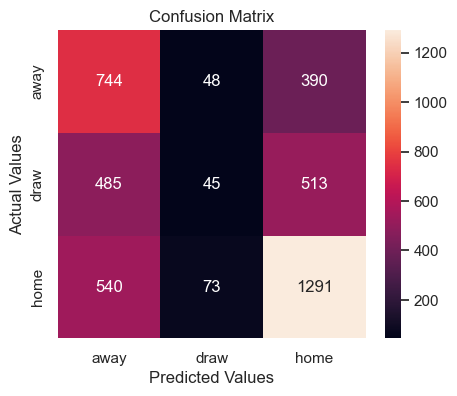

<IPython.core.display.Javascript object>

In [138]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_df,
    annot=True,
    square=True,
    fmt=".0f",
)
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

Next, the performance of the model is evaluated. As can be seen, the model has really problems to predict the 'draw' outcome correctly. 

In [139]:
print("Accuracy score: ", accuracy_score(y_test, prediction["match_outcome"]))
print("F1-score: ", f1_score(y_test, prediction["match_outcome"], average="weighted"))
print(classification_report(y_test, prediction["match_outcome"]))

Accuracy score:  0.5037539355776217
F1-score:  0.4536910287369301
              precision    recall  f1-score   support

        away       0.42      0.63      0.50      1182
        draw       0.27      0.04      0.07      1043
        home       0.59      0.68      0.63      1904

    accuracy                           0.50      4129
   macro avg       0.43      0.45      0.40      4129
weighted avg       0.46      0.50      0.45      4129



<IPython.core.display.Javascript object>

The accuracy of 50% indicates that the model performs better than random guessing, as it correctly predicts half of the instances. However, there is still room for improvement, as the model's performance is not significantly higher than chance. 

#### ROC Curves

In [140]:
binarizer = LabelBinarizer()
y_test_bin = binarizer.fit_transform(y_test)

<IPython.core.display.Javascript object>

In [141]:
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = {}
classes = ["away", "draw", "home"]

for i in range(len(classes)):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_test_bin[:, i], y_hat.values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>

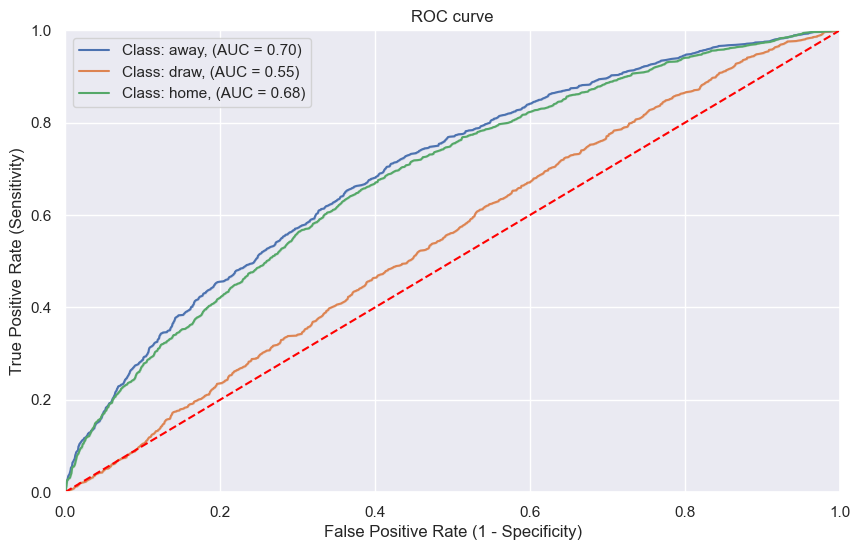

<IPython.core.display.Javascript object>

In [142]:
plt.figure()
for i in range(len(classes)):
    sns.lineplot(
        x=fpr[i], y=tpr[i], label=f"Class: {classes[i]}, (AUC = {roc_auc[i]:.2f})"
    )
sns.lineplot(x=[0, 1], y=[0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title(f"ROC curve")

The area under the ROC curve is estimated with one vs all method. This figure also shows the performance of the model quite well. The home and away results are predicted with decent accuracy, but the draws are missed quite badly. 
As a rule of thumb, it can be said that area larger than 0.7 can be considered as a good classifier.

### 5.2 Predicting match scores

For the score predictor, similar preprocessing is done. Formationsand overall rating values are combined as were with the match outcome predictor classifier.

The target feature for the model is the number goals per team in match. Each match will be presented with two rows. This way the goals for both teams can be predicted. The used model is Poisson refression.

Similar training process is conducted for the Poisson regression model as was with the match outcome classifier. The data is split into training and testing sets. The predictors are standardized. Then backward elimnation is used as a feature selection tehchnique to identify the most significant predictors for the model. Starting with a model including all the features, the features are iteratively removed based on their p-values. 

The most optimal threshold for p-value is selected by comparing five different values. Cross validation is used to evaluate the performance of models during the process. The model with smallest mean absolute error is selected. After that the selected model's performance is evaluated with the test data. The mean absolute error is used instead of root mean squared error as it wont emphasize the impact of outliers and large errors as much as RMSE.

- Target population: European football league matches
- Significance levels: $\alpha = [0.05, 0.1875, 0.325 , 0.4625, 0.6]$

Assumptions for multinomial logistic regression are met.
- Observations are independent from each other.
- Enough large sample size.
- No multicollinearity among the independent variables.


In [143]:
goal_model_df = matches_modelling_df.copy()
goal_model_df = duckdb.query(
    """
SELECT m.* EXCLUDE (
            home_team_api_id,
            away_team_api_id,
            match_api_id, 
            match_outcome,
            date,
            stage,
            league_id,
            season, 
            home_win, 
            away_win, 
            draw)
FROM goal_model_df m
"""
).df()

<IPython.core.display.Javascript object>

In [144]:
goal_model_df = preprocessingtools.calculate_team_ratings_summary(goal_model_df)

<IPython.core.display.Javascript object>

In [145]:
popular_formation = ["442", "4231", "433"]
goal_model_df.loc[
    ~goal_model_df["home_formation"].isin(popular_formation), "home_formation"
] = "other"
goal_model_df.loc[
    ~goal_model_df["away_formation"].isin(popular_formation), "away_formation"
] = "other"

<IPython.core.display.Javascript object>

In [146]:
goal_model_df["formations"] = (
    goal_model_df["home_formation"] + " vs " + goal_model_df["away_formation"]
)
goal_model_df.drop(columns=["home_formation", "away_formation"], inplace=True)

<IPython.core.display.Javascript object>

Here the matches are divided into two rows so that in the first row the predicted team is home team and in the second row the predicted team is away team. A new feature 'team_home' is used the show if the predicted team is playing at home.

In [147]:
mapping_home = {"home": "team_", "away": "opponent_"}
mapping_away = {"away": "team_", "home": "opponent_"}

<IPython.core.display.Javascript object>

In [148]:
goal_model_df = pd.concat(
    [
        goal_model_df.assign(team_home=1).rename(
            columns=lambda x: mapping_home[x.split("_", 1)[0]] + x.split("_", 1)[1]
            if x.split("_")[0] in mapping_home
            else x
        ),
        goal_model_df.assign(team_home=0).rename(
            columns=lambda x: mapping_away[x.split("_", 1)[0]] + x.split("_", 1)[1]
            if x.split("_")[0] in mapping_away
            else x
        ),
    ]
)
goal_model_df.rename(columns={"team_team_goal": "goals"}, inplace=True)
goal_model_df.drop(columns="opponent_team_goal", inplace=True)

<IPython.core.display.Javascript object>

Now the last match outcome feature is modified so that it will give '1' if the team won, and '-1' if the opponent won.

In [149]:
goal_model_df.loc[goal_model_df["team_home"] == 1, "last_match_outcome"] *= -1

<IPython.core.display.Javascript object>

In [150]:
goal_model_df

goals  team_points_history  opponent_points_history  \
0          0                  8.0                     13.0   
1          1                  6.0                     11.0   
2          2                  7.0                     13.0   
3          1                 11.0                     10.0   
4          0                 13.0                      9.0   
...      ...                  ...                      ...   
16510      0                  3.0                      4.0   
16511      0                 10.0                      7.0   
16512      1                  7.0                      9.0   
16513      0                  5.0                      8.0   
16514      4                  7.0                      4.0   

       last_match_outcome  team_goals_history  opponent_goals_history  \
0                       0                 1.3                1.700000   
1                       1                 1.2                1.700000   
2                       0                 1.0                2.000000   
3                       0                 1.8                1.700000   
4                      -1                 1.5                1.800000   
...                   ...                 ...                     ...   
16510                   0                 1.0                1.400000   
16511                   1                 0.6                1.200000   
16512                  -1                 1.0                0.800000   
16513                   0                 1.5                0.888889   
16514                   0                 1.2                0.900000   

       last_match_goal_difference  team_buildUpPlaySpeed  \
0                               0                     50   
1                              -1                     45   
2                               0                     45   
3                               0                     53   
4                               1                     65   
...                           ...                    ...   
16510                           0                     67   
16511                           1                     53   
16512                          -1                     65   
16513                           0                     52   
16514                           0                     53   

       team_buildUpPlayPassing  team_chanceCreationPassing  ...  \
0                           60                          50  ...   
1                           45                          50  ...   
2                           60                          40  ...   
3                           40                          55  ...   
4                           60                          50  ...   
...                        ...                         ...  ...   
16510                       35                          69  ...   
16511                       43                          52  ...   
16512                       40                          60  ...   
16513                       40                          47  ...   
16514                       55                          55  ...   

       opponent_chanceCreationCrossing  opponent_chanceCreationShooting  \
0                                   50                               60   
1                                   40                               50   
2                                   55                               65   
3                                   40                               50   
4                                   50                               60   
...                                ...                              ...   
16510                               45                               23   
16511                               55                               32   
16512                               40                               50   
16513                               42                               53   
16514                             

<IPython.core.display.Javascript object>

In [151]:
X = goal_model_df.loc[:, ~goal_model_df.columns.isin(["goals"])]
y = goal_model_df["goals"]

<IPython.core.display.Javascript object>

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

<IPython.core.display.Javascript object>

In [153]:
scaler = StandardScaler().fit(
    X_train.loc[:, ~X_train.columns.isin(["team_home", "formations"])]
)
X_train.loc[:, ~X_train.columns.isin(["team_home", "formations"])] = scaler.transform(
    X_train.loc[:, ~X_train.columns.isin(["team_home", "formations"])]
)
X_test.loc[:, ~X_test.columns.isin(["team_home", "formations"])] = scaler.transform(
    X_test.loc[:, ~X_test.columns.isin(["team_home", "formations"])]
)

<IPython.core.display.Javascript object>

In [154]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

<IPython.core.display.Javascript object>

Training and backward elimination of features with comparison of different p-values.

In [155]:
alpha_list = np.linspace(0.05, 0.6, 5)
model_fit = featureselection.model_selection_Poisson(X_train, y_train, alpha_list, 5)

****************************************************************************************************
Fold 0
Initial Model Summary:
Performing backward elimination.

feature_index: team_points_history
Feature team_points_history dropped.
Pvalue: 0.9855415664462477.
feature_index: formations_4231 vs 442
Feature formations_4231 vs 442 dropped.
Pvalue: 0.9618924971993376.
feature_index: opponent_buildUpPlaySpeed
Feature opponent_buildUpPlaySpeed dropped.
Pvalue: 0.9461369300926096.
feature_index: formations_442 vs 433
Feature formations_442 vs 433 dropped.
Pvalue: 0.9319417665548557.
feature_index: formations_433 vs other
Feature formations_433 vs other dropped.
Pvalue: 0.9466634849300161.
feature_index: formations_4231 vs 4231
Feature formations_4231 vs 4231 dropped.
Pvalue: 0.9680243644107324.
feature_index: formations_433 vs 442
Feature formations_433 vs 442 dropped.
Pvalue: 0.7967406403235391.
feature_index: formations_other vs 4231
Feature formations_other vs 4231 dropped.
Pvalue: 0.7

Feature formations_433 vs 4231 dropped.
Pvalue: 0.42610305931835446.
feature_index: opponent_buildUpPlaySpeed
Feature opponent_buildUpPlaySpeed dropped.
Pvalue: 0.4304455204045162.
feature_index: team_chanceCreationPassing
Feature team_chanceCreationPassing dropped.
Pvalue: 0.41063128763325474.

Backward elimination completed with 20 rounds.

Final Model Summary:
Number of features: 22
Significance level: 0.325
Mean absolute error: 1.204
****************************************************************************************************
Fold 3
Initial Model Summary:
Performing backward elimination.

feature_index: formations_433 vs 442
Feature formations_433 vs 442 dropped.
Pvalue: 0.9960013508964121.
feature_index: opponent_defencePressure
Feature opponent_defencePressure dropped.
Pvalue: 0.9575379042659125.
feature_index: formations_4231 vs other
Feature formations_4231 vs other dropped.
Pvalue: 0.9447168596431998.
feature_index: formations_433 vs other
Feature formations_433 vs othe

<IPython.core.display.Javascript object>

In [156]:
print(model_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                19818
Model:                            GLM   Df Residuals:                    19796
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28809.
Date:                Thu, 18 May 2023   Deviance:                       22444.
Time:                        14:21:26   Pearson chi2:                 1.96e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1364
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

<IPython.core.display.Javascript object>

Based on the selected features, we can conclude that some of the findings from the EDA are confirmed with the model. The historical features and playing formations have impact to the match outcome. 

The all the coefficients are quite moderate in scale. The home advantage (team_home) has the highest impact on the predicted scores by the team. This is also confirmed in the statistical analysis. In addition, the player overall ratings have also higher coefficients compared to other predictors. Similarly as with the classifier model.

In [157]:
y_hat = model_fit.predict(X_test[model_fit.params.index])
predicted_goals = np.random.poisson(y_hat)
residuals = y_test - predicted_goals

<IPython.core.display.Javascript object>

In [158]:
print(
    "Root Mean Squared Error (RMSE):",
    np.sqrt(mean_squared_error(y_test, predicted_goals)),
)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predicted_goals))

Root Mean Squared Error (RMSE): 1.657782894985722
Mean Absolute Error (MAE): 1.2304432065875515


<IPython.core.display.Javascript object>

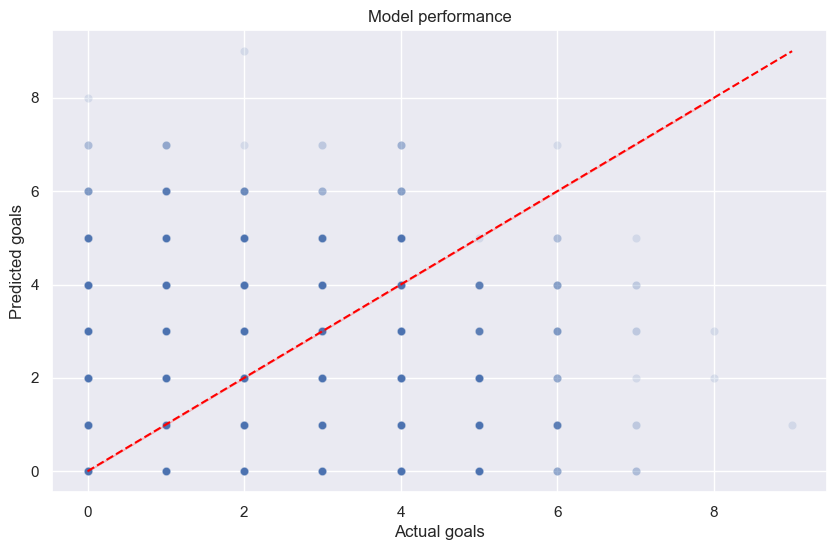

<IPython.core.display.Javascript object>

In [159]:
ax = sns.scatterplot(x=y_test, y=predicted_goals, alpha=0.15)
sns.lineplot(x=y_test, y=y_test, color="red", linestyle="--", ax=ax)
ax.set_xlabel("Actual goals")
ax.set_ylabel("Predicted goals")
ax.set_title("Model performance")

It seems that the model underpredicts the higher number of goals and overpredicts the smaller number of goals. The accuracy of the model is not in a sufficient level for betting in football.

In [160]:
goal_distributions = pd.DataFrame()
goal_distributions["actual"] = y_test
goal_distributions["predicted"] = predicted_goals
goal_distributions["poisson_distribution"] = np.random.poisson(
    y_test.mean(), len(y_test)
)

<IPython.core.display.Javascript object>

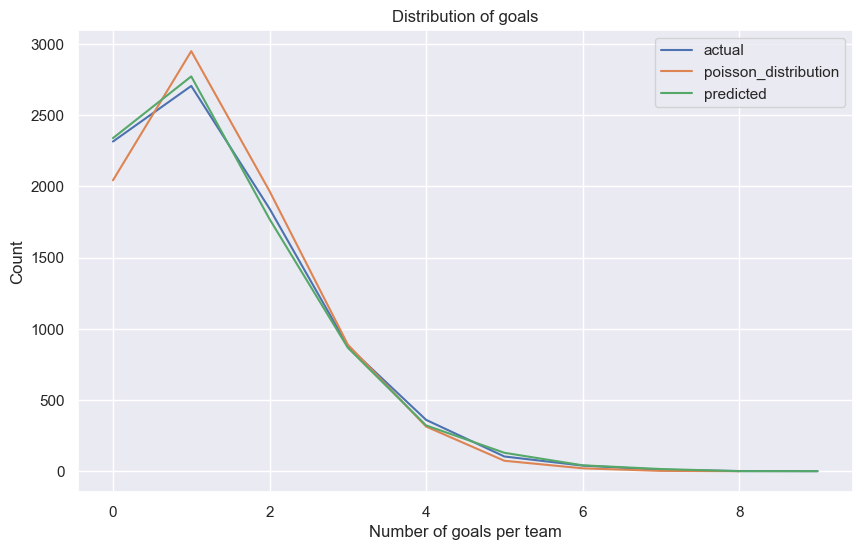

<IPython.core.display.Javascript object>

In [161]:
ax = goal_distributions.actual.value_counts().sort_index().plot()
goal_distributions.poisson_distribution.value_counts().sort_index().plot(ax=ax)
goal_distributions.predicted.value_counts().sort_index().plot(ax=ax)
ax.legend()
ax.set_title("Distribution of goals")
ax.set_ylabel("Count")
ax.set_xlabel("Number of goals per team")

As can be seen the dependent variable (goals) follows Poisson distribution very closely.

In [162]:
print(f"The mean of all the goals {goal_model_df.goals.mean():.2f}")
print(f"The variance of all the goals {goal_model_df.goals.var():.2f}")

The mean of all the goals 1.37
The variance of all the goals 1.56


<IPython.core.display.Javascript object>

However, the assumption of equal mean and variance of the dependent variable is not fulfilled. This suggest that the Poisson regression model can not fully account the actual variance from the data.

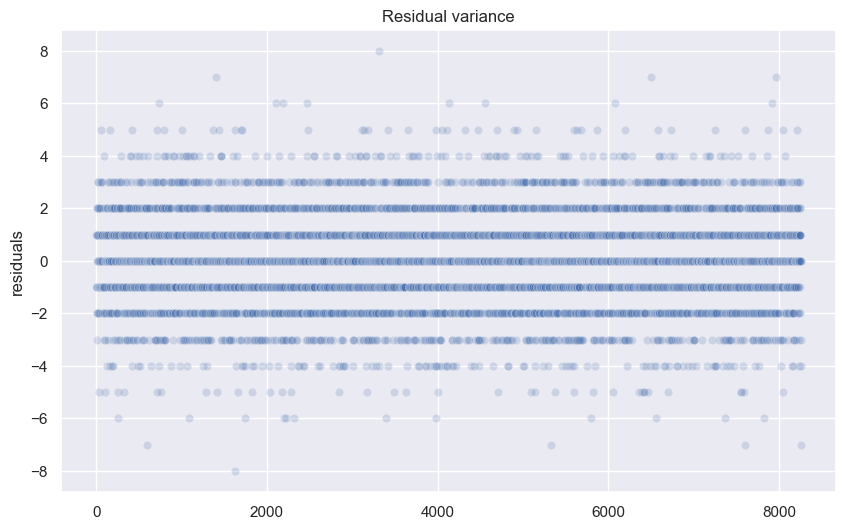

<IPython.core.display.Javascript object>

In [163]:
sns.scatterplot(x=np.arange(len(y_test)), y=residuals, alpha=0.2)
plt.title("Residual variance")
plt.ylabel("residuals")

The residuals are scattered quite constantly over all the fitted values.

## 6. Conclusion

A data analysis is conducted for a football dataset. The aim of the analysis is to identify relevant information for betting and study the possibility to built a predicting model for match outcomes and scores.

The main research questions are:
1. Which leagues are in which countries?
2. Which leagues score the most/fewest goals?
3. Who are the top scorers in each team and league?
4. Can we identify teams with high winning rate?
5. Is there such a thing as home advantage?
6. Do teams make more goals at home?
7. Can we predict how many goals each team will score in each match?
8. Can we predict which team will win the match?

Based on exploratory and statiscal analysis we can conclude that
1. There are ten leagues from ten countries in the data set.
2. In the Netherlands Eredivisie matches are made the most goals in average, and in the France Ligue 1 matches the least.
3. The top scorers are listed for each team and league. The player with highest number of goals is Messi.
4. There is no clear pattern for teams with high winning rate. However, we can conclude that
    - There is no correlation between team attributes and winning rate
    - The player overall ratings has only small impact to the match outcome.
    - The playing formation has some impact to the winning rate and goal making. From the most popular formations, teams using the 433 tactic have the best performance.
    - The historical performance of the team has higher impact to the current match outcome. Teams that have player well recently tend to win.
    - Similar findings are made also for the goal making.
5. Based on statistical analysis we can conclude with 95% confidence that home teams have higher winning rate in average.
6. This is also true for average number of goals. Home teams tend to make more goals also.
7. (8.) Predicting match outcome is difficult with the current dataset. 
    - A multiclass classifier is trained with 50% accuracy, which gives plenty of room for improvement.
    - Similarly with the predicting scores for both teams, the forecasting has large uncertainties. The model predicts the scores with 1.2 goals absolute mean error. 
    - The models are not suitable for creating betting odds for future match at the moment.

All in all, the football is a hard sport to predict. The human factor is important and can change the outcome of the match easily.

### Future remarks
- Using attac/defence power features to improve model accuracy. These kind of features could be built with player coordinates and attributes.
- Testing a non-linear models to improve predicting accuracy.
- Check for outliers with high influence, e.g. using cook's distance as a threshold
- Create historical features from the in-game data to improve the model accuracy
    - Posession
    - Shotson
    - Number of yellow/red cards etc